# `CNRatioModel` Hyperfine Anomalies

Trey V. Wenger (c) December 2024

Here we demonstrate how to handle hyperfine anomalies with the `CNRatioModel`. The excitation temperature of $^{13}{\rm CN}$ is challenging to determine because the spectral features are numerous and weak. With `CNRatioModel` we can either (1) assume that $^{13}{\rm CN}$ does not suffer from hyperfine anomalies and assume the average $^{12}{\rm CN}$ excitation temperature for all $^{13}{\rm CN}$ transitions, or (2) assume that the $^{13}{\rm CN}$ hyperfine anomalies are similar to the $^{12}{\rm CN}$ anomalies.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("arviz version:", az.__version__)

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

arviz version: 0.22.0dev
pymc version: 5.21.1
bayes_spec version: 1.7.4
bayes_cn_hfs version: 1.1.1+6.g94944ab.dirty


## Simulate Data

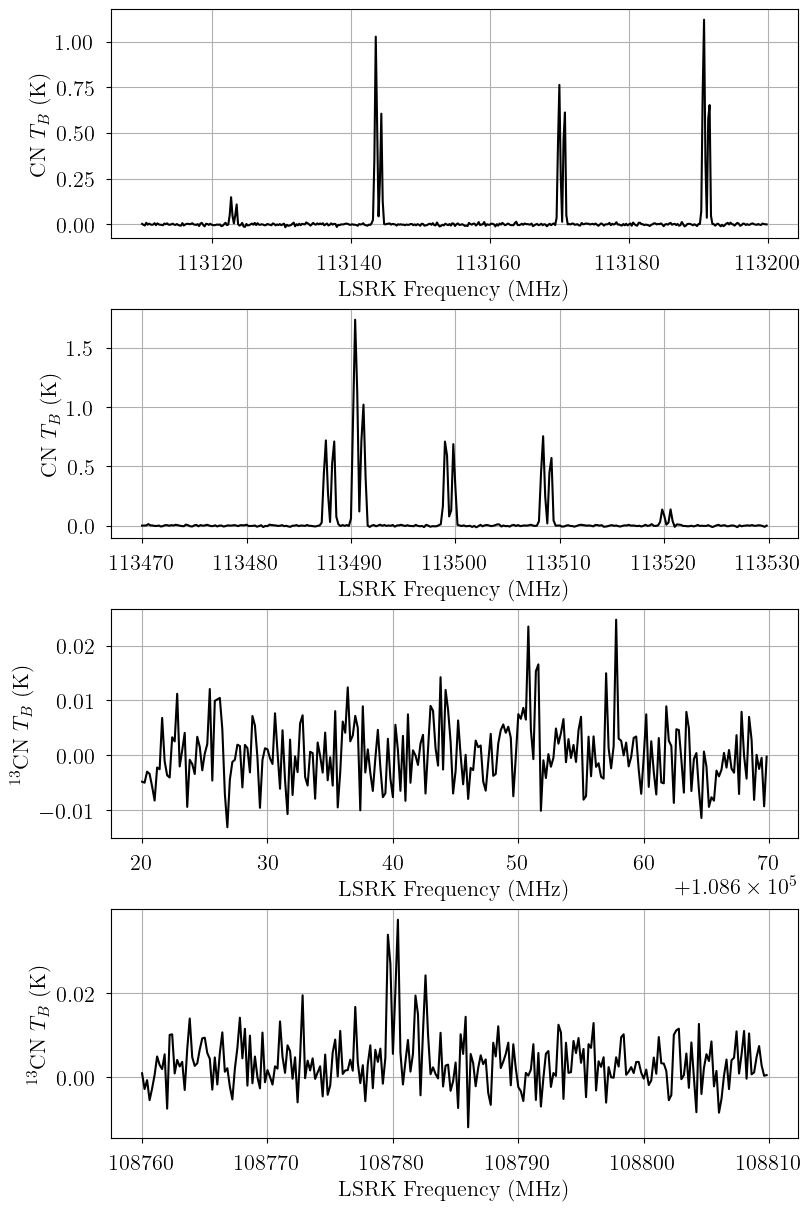

In [2]:
from bayes_spec import SpecData
from bayes_cn_hfs.cn_ratio_model import CNRatioModel

# spectral axis definition
freq_axis_12CN_1 = np.arange(113110.0, 113200.0, 0.2) # MHz
freq_axis_12CN_2 = np.arange(113470.0, 113530.0, 0.2) # MHz
freq_axis_13CN_1 = np.arange(108620.0, 108670.0, 0.2) # MHz
freq_axis_13CN_2 = np.arange(108760.0, 108810.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.005 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_12CN_1 = noise * np.random.randn(len(freq_axis_12CN_1)) # K
brightness_data_12CN_2 = noise * np.random.randn(len(freq_axis_12CN_2)) # K
brightness_data_13CN_1 = noise * np.random.randn(len(freq_axis_13CN_1)) # K
brightness_data_13CN_2 = noise * np.random.randn(len(freq_axis_13CN_2)) # K

# CNRatioModel expects observation names to contain either "12CN" or "13CN"
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    brightness_data_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    brightness_data_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    brightness_data_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    brightness_data_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
dummy_data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}

# Initialize and define the model
n_clouds = 2 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNRatioModel(
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.75, 0.25], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [75.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = [0.5, 0.1], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.1], # mean and width of excitation temperature prior (K)
    assume_CTEX_12CN = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    assume_CTEX_13CN = True, # assume CTEX for 13CN
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N_12CN": [13.9, 13.8],
    "ratio_12C_13C": [65.0, 55.0],
    "log10_Tkin": [0.6, 0.7],
    "velocity": [-0.5, 1.5],
    "fwhm_nonthermal": [0.5, 0.75],
    "fwhm_L": 0.0,
    "log10_Tex_ul": [0.6, 0.7],
    "LTE_precision": [1.0e-4, 1.0e-3],
    "baseline_12CN_norm": [0.0],
    "baseline_13CN_norm": [0.0],
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
sim_12CN_1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_12CN_2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")
sim_13CN_1 = model.model["13CN-1"].eval(sim_params, on_unused_input="ignore")
sim_13CN_2 = model.model["13CN-2"].eval(sim_params, on_unused_input="ignore")

# pack simulated data
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    sim_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    sim_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    sim_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    sim_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}

# Plot the simulated data
fig, axes = plt.subplots(4, layout="constrained", figsize=(8, 12))
for i, dataset in enumerate(data.values()):
    axes[i].plot(dataset.spectral, dataset.brightness, 'k-')
    axes[i].set_ylabel(dataset.ylabel)
    _ = axes[i].set_xlabel(dataset.xlabel)

In [3]:
sim_params

{'log10_N_12CN': [13.9, 13.8],
 'ratio_12C_13C': [65.0, 55.0],
 'log10_Tkin': [0.6, 0.7],
 'velocity': [-0.5, 1.5],
 'fwhm_nonthermal': [0.5, 0.75],
 'fwhm_L': 0.0,
 'log10_Tex_ul': [0.6, 0.7],
 'LTE_precision': [0.0001, 0.001],
 'baseline_12CN_norm': [0.0],
 'baseline_13CN_norm': [0.0],
 'fwhm_thermal_12CN': array([0.08371703, 0.09393205]),
 'fwhm_thermal_13CN': array([0.08215209, 0.09217616]),
 'fwhm_12CN': array([0.5069601 , 0.75585927]),
 'fwhm_13CN': array([0.50670402, 0.75564307]),
 'N_13CN': array([1.22204344e+12, 1.14719517e+12]),
 'Tex_12CN': array([[3.8423276 , 4.85592549],
        [3.78250698, 5.8915345 ],
        [3.99070947, 4.67986351],
        [3.92621605, 5.63392175],
        [3.96392977, 4.23662943],
        [4.01394838, 5.22962859],
        [3.99750278, 4.66638693],
        [3.90047211, 5.00128406],
        [3.93297435, 5.61109994]]),
 'tau_12CN': array([[0.03982563, 0.02826438],
        [0.33574858, 0.17002794],
        [0.31287068, 0.23049357],
        [0.41863835, 

## Model Definition
We fix the kinetic temperature and assume CTEX for $^{13}{\rm CN}$. The $^{13}{\rm CN}$ excitation temperature is fixed at the average $^{12}{\rm CN}$ excitation temperature.

In [4]:
# Initialize and define the model
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.75, 0.25], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [75.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = None, # kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.1], # mean and width of excitation temperature prior (K)
    assume_CTEX_12CN = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    assume_CTEX_13CN = True, # assume CTEX for 13CN
    fix_log10_Tkin = 1.5, # kinetic temperature is fixed (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, log10_Tex_ul_norm, ratio_12C_13C, velocity_norm, weights_12CN]


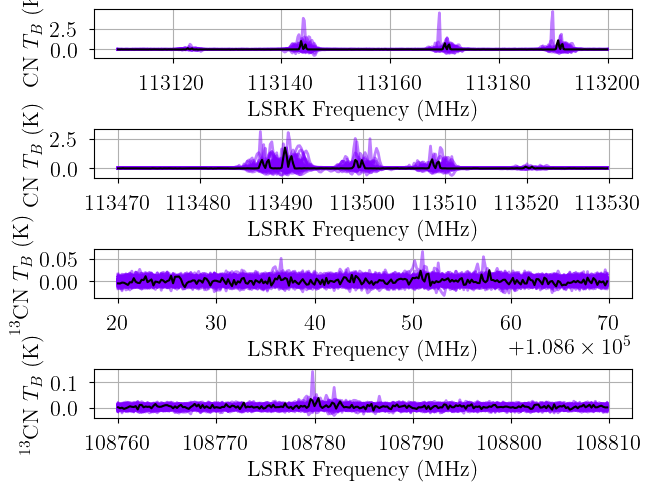

In [5]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [6]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.02, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5300
Interrupted at 5,299 [5%]: Average Loss = 1.682e+05


Output()

Runtime: 0.82 minutes


In [7]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_freeRVs + model.hyper_deterministics + model.baseline_freeRVs + ["LTE_precision", "ratio_12C_13C"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean            sd        hdi_3%  \
velocity[0]             -4.840000e-01  1.000000e-03 -4.860000e-01   
velocity[1]              1.495000e+00  1.000000e-03  1.493000e+00   
fwhm_thermal_12CN[0]     2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_12CN[1]     2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_13CN[0]     2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_thermal_13CN[1]     2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_nonthermal[0]       4.520000e-01  3.000000e-03  4.460000e-01   
fwhm_nonthermal[1]       7.550000e-01  2.000000e-03  7.510000e-01   
fwhm_12CN[0]             5.100000e-01  3.000000e-03  5.050000e-01   
fwhm_12CN[1]             7.910000e-01  2.000000e-03  7.870000e-01   
fwhm_13CN[0]             5.080000e-01  3.000000e-03  5.030000e-01   
fwhm_13CN[1]             7.900000e-01  2.000000e-03  7.860000e-01   
log10_N_12CN[0]          1.390200e+01  2.000000e-03  1.389800e+01   
log10_N_12CN[1]          1.374300e+01  1.000000e-03  1.374100e+01   
N_13CN[0]                1.326753e+12  1.309494e+11  1.074382e+12   
N_13CN[1]                9.659394e+11  8.592999e+10  8.212675e+11   
log10_Tex_ul[0]          5.970000e-01  7.000000e-03  5.840000e-01   
log10_Tex_ul[1]          7.220000e-01  2.600000e-02  6.780000e-01   
tau_total_12CN[0]        3.288000e+00  1.700000e-02  3.260000e+00   
tau_total_12CN[1]        1.665000e+00  5.000000e-03  1.656000e+00   
tau_total_13CN[0]        5.100000e-02  5.000000e-03  4.200000e-02   
tau_total_13CN[1]        2.700000e-02  3.000000e-03  2.200000e-02   
fwhm_L_norm              1.000000e-03  2.000000e-03  0.000000e+00   
fwhm_L                   1.000000e-03  2.000000e-03  0.000000e+00   
baseline_12CN-1_norm[0] -1.470000e-01  5.500000e-02 -2.440000e-01   
baseline_12CN-2_norm[0] -2.570000e-01  6.700000e-02 -3.750000e-01   
baseline_13CN-1_norm[0] -1.130000e-01  6.400000e-02 -2.320000e-01   
baseline_13CN-2_norm[0] -1.900000e-02  6.800000e-02 -1.380000e-01   
LTE_precision[0]         0.000000e+00  0.000000e+00  0.000000e+00   
LTE_precision[1]         3.000000e-03  2.000000e-03  1.000000e-03   
ratio_12C_13C[0]         6.069200e+01  5.939000e+00  4.842100e+01   
ratio_12C_13C[1]         5.777800e+01  5.163000e+00  4.887400e+01   

                              hdi_97%     mcse_mean       mcse_sd  ess_bulk  \
velocity[0]             -4.820000e-01  0.000000e+00  0.000000e+00     849.0   
velocity[1]              1.497000e+00  0.000000e+00  0.000000e+00    1023.0   
fwhm_thermal_12CN[0]     2.360000e-01  0.000000e+00  0.000000e+00    1000.0   
fwhm_thermal_12CN[1]     2.360000e-01  0.000000e+00  0.000000e+00    1000.0   
fwhm_thermal_13CN[0]     2.320000e-01  0.000000e+00  0.000000e+00    1000.0   
fwhm_thermal_13CN[1]     2.320000e-01  0.000000e+00  0.000000e+00    1000.0   
fwhm_nonthermal[0]       4.590000e-01  0.000000e+00  0.000000e+00    1007.0   
fwhm_nonthermal[1]       7.590000e-01  0.000000e+00  0.000000e+00     934.0   
fwhm_12CN[0]             5.160000e-01  0.000000e+00  0.000000e+00    1007.0   
fwhm_12CN[1]             7.950000e-01  0.000000e+00  0.000000e+00     934.0   
fwhm_13CN[0]             5.140000e-01  0.000000e+00  0.000000e+00    1007.0   
fwhm_13CN[1]             7.930000e-01  0.000000e+00  0.000000e+00     934.0   
log10_N_12CN[0]          1.390600e+01  0.000000e+00  0.000000e+00     844.0   
log10_N_12CN[1]          1.374500e+01  0.000000e+00  0.000000e+00     907.0   
N_13CN[0]                1.562702e+12  4.289080e+09  3.296495e+09     930.0   
N_13CN[1]                1.135508e+12  2.827358e+09  1.962590e+09     920.0   
log10_Tex_ul[0]          6.110000e-01  0.000000e+00  0.000000e+00     949.0   
log10_Tex_ul[1]          7.750000e-01  1.000000e-03  1.000000e-03     993.0   
tau_total_12CN[0]        3.322000e+00  1.000000e-03  0.000000e+00     854.0   
tau_total_12CN[1]        1.674000e+00  0.000000e+00  0.000000e+00    1073.0   
tau_total_13CN[0]        6.100000e-02  0.000000e+00  0.000000e+00     949.0   
tau_total_13CN[1]

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

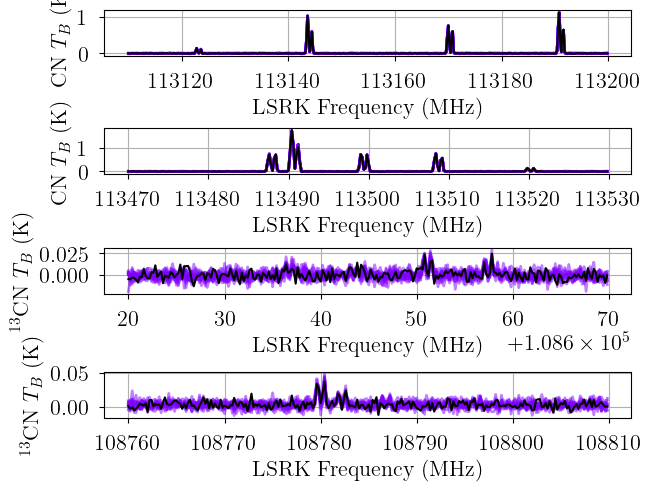

In [8]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

In [9]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.02}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5300
Interrupted at 5,299 [5%]: Average Loss = 1.682e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_12CN_norm, ratio_12C_13C, log10_Tex_ul_norm, LTE_precision, weights_12CN]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 366 seconds.


Adding log-likelihood to trace


Output()

Runtime: 7.19 minutes


In [10]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [11]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs + ["ratio_12C_13C", "LTE_precision"])

solutions: [0]


/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean            sd        hdi_3%  \
velocity[0]             -5.000000e-01  1.000000e-03 -5.020000e-01   
velocity[1]              1.500000e+00  1.000000e-03  1.498000e+00   
fwhm_thermal_12CN[0]     2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_12CN[1]     2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_13CN[0]     2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_thermal_13CN[1]     2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_nonthermal[0]       4.420000e-01  7.000000e-03  4.300000e-01   
fwhm_nonthermal[1]       7.210000e-01  4.000000e-03  7.130000e-01   
fwhm_12CN[0]             5.010000e-01  6.000000e-03  4.900000e-01   
fwhm_12CN[1]             7.590000e-01  4.000000e-03  7.510000e-01   
fwhm_13CN[0]             4.990000e-01  6.000000e-03  4.880000e-01   
fwhm_13CN[1]             7.570000e-01  4.000000e-03  7.490000e-01   
log10_N_12CN[0]          1.390700e+01  9.000000e-03  1.389100e+01   
log10_N_12CN[1]          1.380200e+01  6.000000e-03  1.379100e+01   
N_13CN[0]                1.302064e+12  1.350778e+11  1.044075e+12   
N_13CN[1]                1.071082e+12  1.475038e+11  8.043208e+11   
log10_Tex_ul[0]          5.960000e-01  9.000000e-03  5.790000e-01   
log10_Tex_ul[1]          6.890000e-01  3.400000e-02  6.200000e-01   
tau_total_12CN[0]        3.374000e+00  8.200000e-02  3.216000e+00   
tau_total_12CN[1]        2.043000e+00  4.300000e-02  1.962000e+00   
tau_total_13CN[0]        5.000000e-02  6.000000e-03  3.900000e-02   
tau_total_13CN[1]        3.300000e-02  7.000000e-03  2.100000e-02   
fwhm_L                   4.000000e-03  2.000000e-03  0.000000e+00   
baseline_12CN-1_norm[0] -1.080000e-01  4.900000e-02 -2.000000e-01   
baseline_12CN-2_norm[0] -2.740000e-01  6.300000e-02 -3.920000e-01   
baseline_13CN-1_norm[0] -1.230000e-01  6.600000e-02 -2.480000e-01   
baseline_13CN-2_norm[0] -3.600000e-02  6.500000e-02 -1.580000e-01   
ratio_12C_13C[0]         6.270000e+01  6.692000e+00  5.019300e+01   
ratio_12C_13C[1]         6.032500e+01  8.057000e+00  4.589600e+01   
LTE_precision[0]         0.000000e+00  0.000000e+00  0.000000e+00   
LTE_precision[1]         3.000000e-03  3.000000e-03  0.000000e+00   

                              hdi_97%     mcse_mean       mcse_sd  ess_bulk  \
velocity[0]             -4.980000e-01  0.000000e+00  0.000000e+00    6733.0   
velocity[1]              1.502000e+00  0.000000e+00  0.000000e+00   11183.0   
fwhm_thermal_12CN[0]     2.360000e-01  0.000000e+00  0.000000e+00    8000.0   
fwhm_thermal_12CN[1]     2.360000e-01  0.000000e+00  0.000000e+00    8000.0   
fwhm_thermal_13CN[0]     2.320000e-01  0.000000e+00  0.000000e+00    8000.0   
fwhm_thermal_13CN[1]     2.320000e-01  0.000000e+00  0.000000e+00    8000.0   
fwhm_nonthermal[0]       4.550000e-01  0.000000e+00  0.000000e+00    2126.0   
fwhm_nonthermal[1]       7.290000e-01  0.000000e+00  0.000000e+00    2441.0   
fwhm_12CN[0]             5.120000e-01  0.000000e+00  0.000000e+00    2126.0   
fwhm_12CN[1]             7.660000e-01  0.000000e+00  0.000000e+00    2441.0   
fwhm_13CN[0]             5.100000e-01  0.000000e+00  0.000000e+00    2126.0   
fwhm_13CN[1]             7.650000e-01  0.000000e+00  0.000000e+00    2441.0   
log10_N_12CN[0]          1.392500e+01  0.000000e+00  0.000000e+00    1850.0   
log10_N_12CN[1]          1.381400e+01  0.000000e+00  0.000000e+00    2013.0   
N_13CN[0]                1.550039e+12  1.654574e+09  1.501051e+09    6570.0   
N_13CN[1]                1.341493e+12  2.159314e+09  2.409470e+09    5171.0   
log10_Tex_ul[0]          6.130000e-01  0.000000e+00  0.000000e+00    4349.0   
log10_Tex_ul[1]          7.470000e-01  0.000000e+00  0.000000e+00    4938.0   
tau_total_12CN[0]        3.521000e+00  2.000000e-03  1.000000e-03    1843.0   
tau_total_12CN[1]        2.123000e+00  1.000000e-03  1.000000e-03    1996.0   
tau_total_13CN[0]        6.100000e-02  0.000000e+00  0.000000e+00    5302.0   
tau_total_13CN[1]        4.600000e-02  0.000000e+00  0.000000e+00    4692.0   
fwhm_L 

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

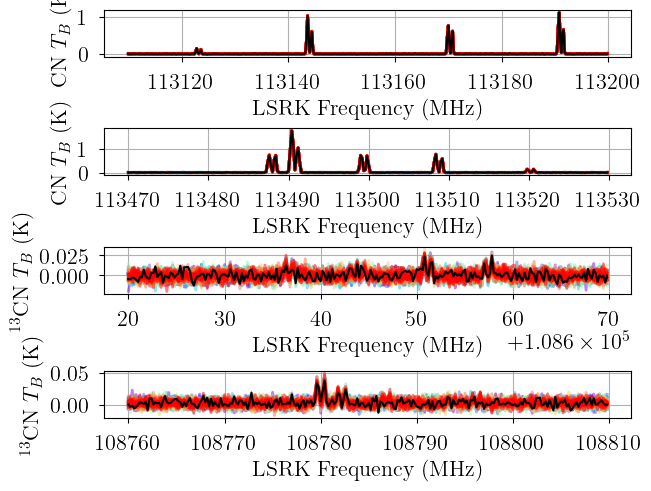

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

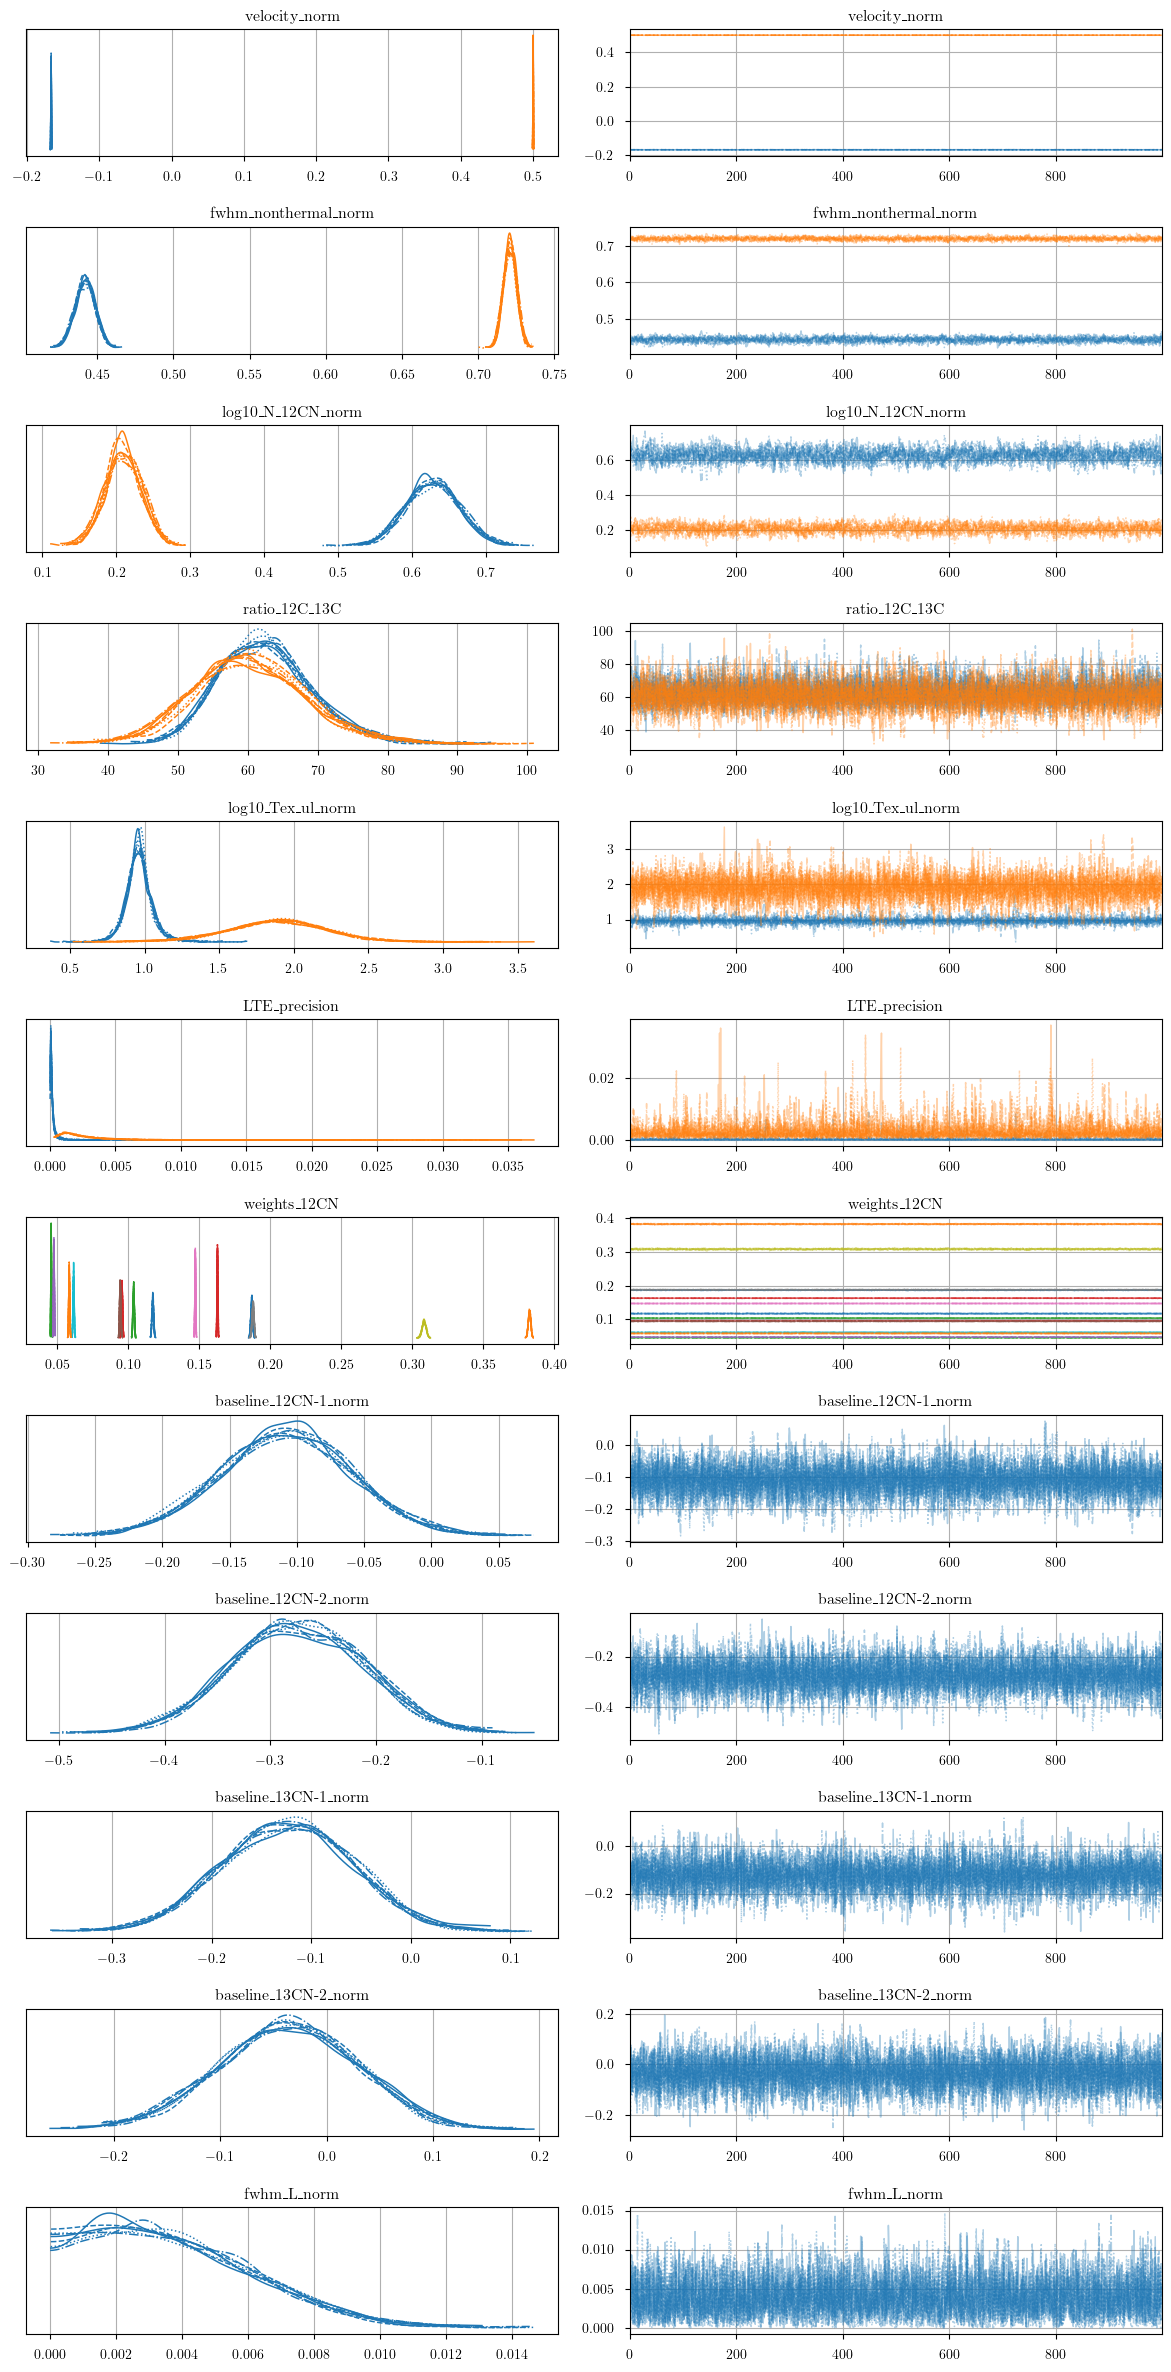

In [13]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

['velocity', 'fwhm_nonthermal', 'fwhm_12CN', 'fwhm_13CN', 'log10_N_12CN', 'N_13CN', 'log10_Tex_ul', 'tau_total_12CN', 'tau_total_13CN']


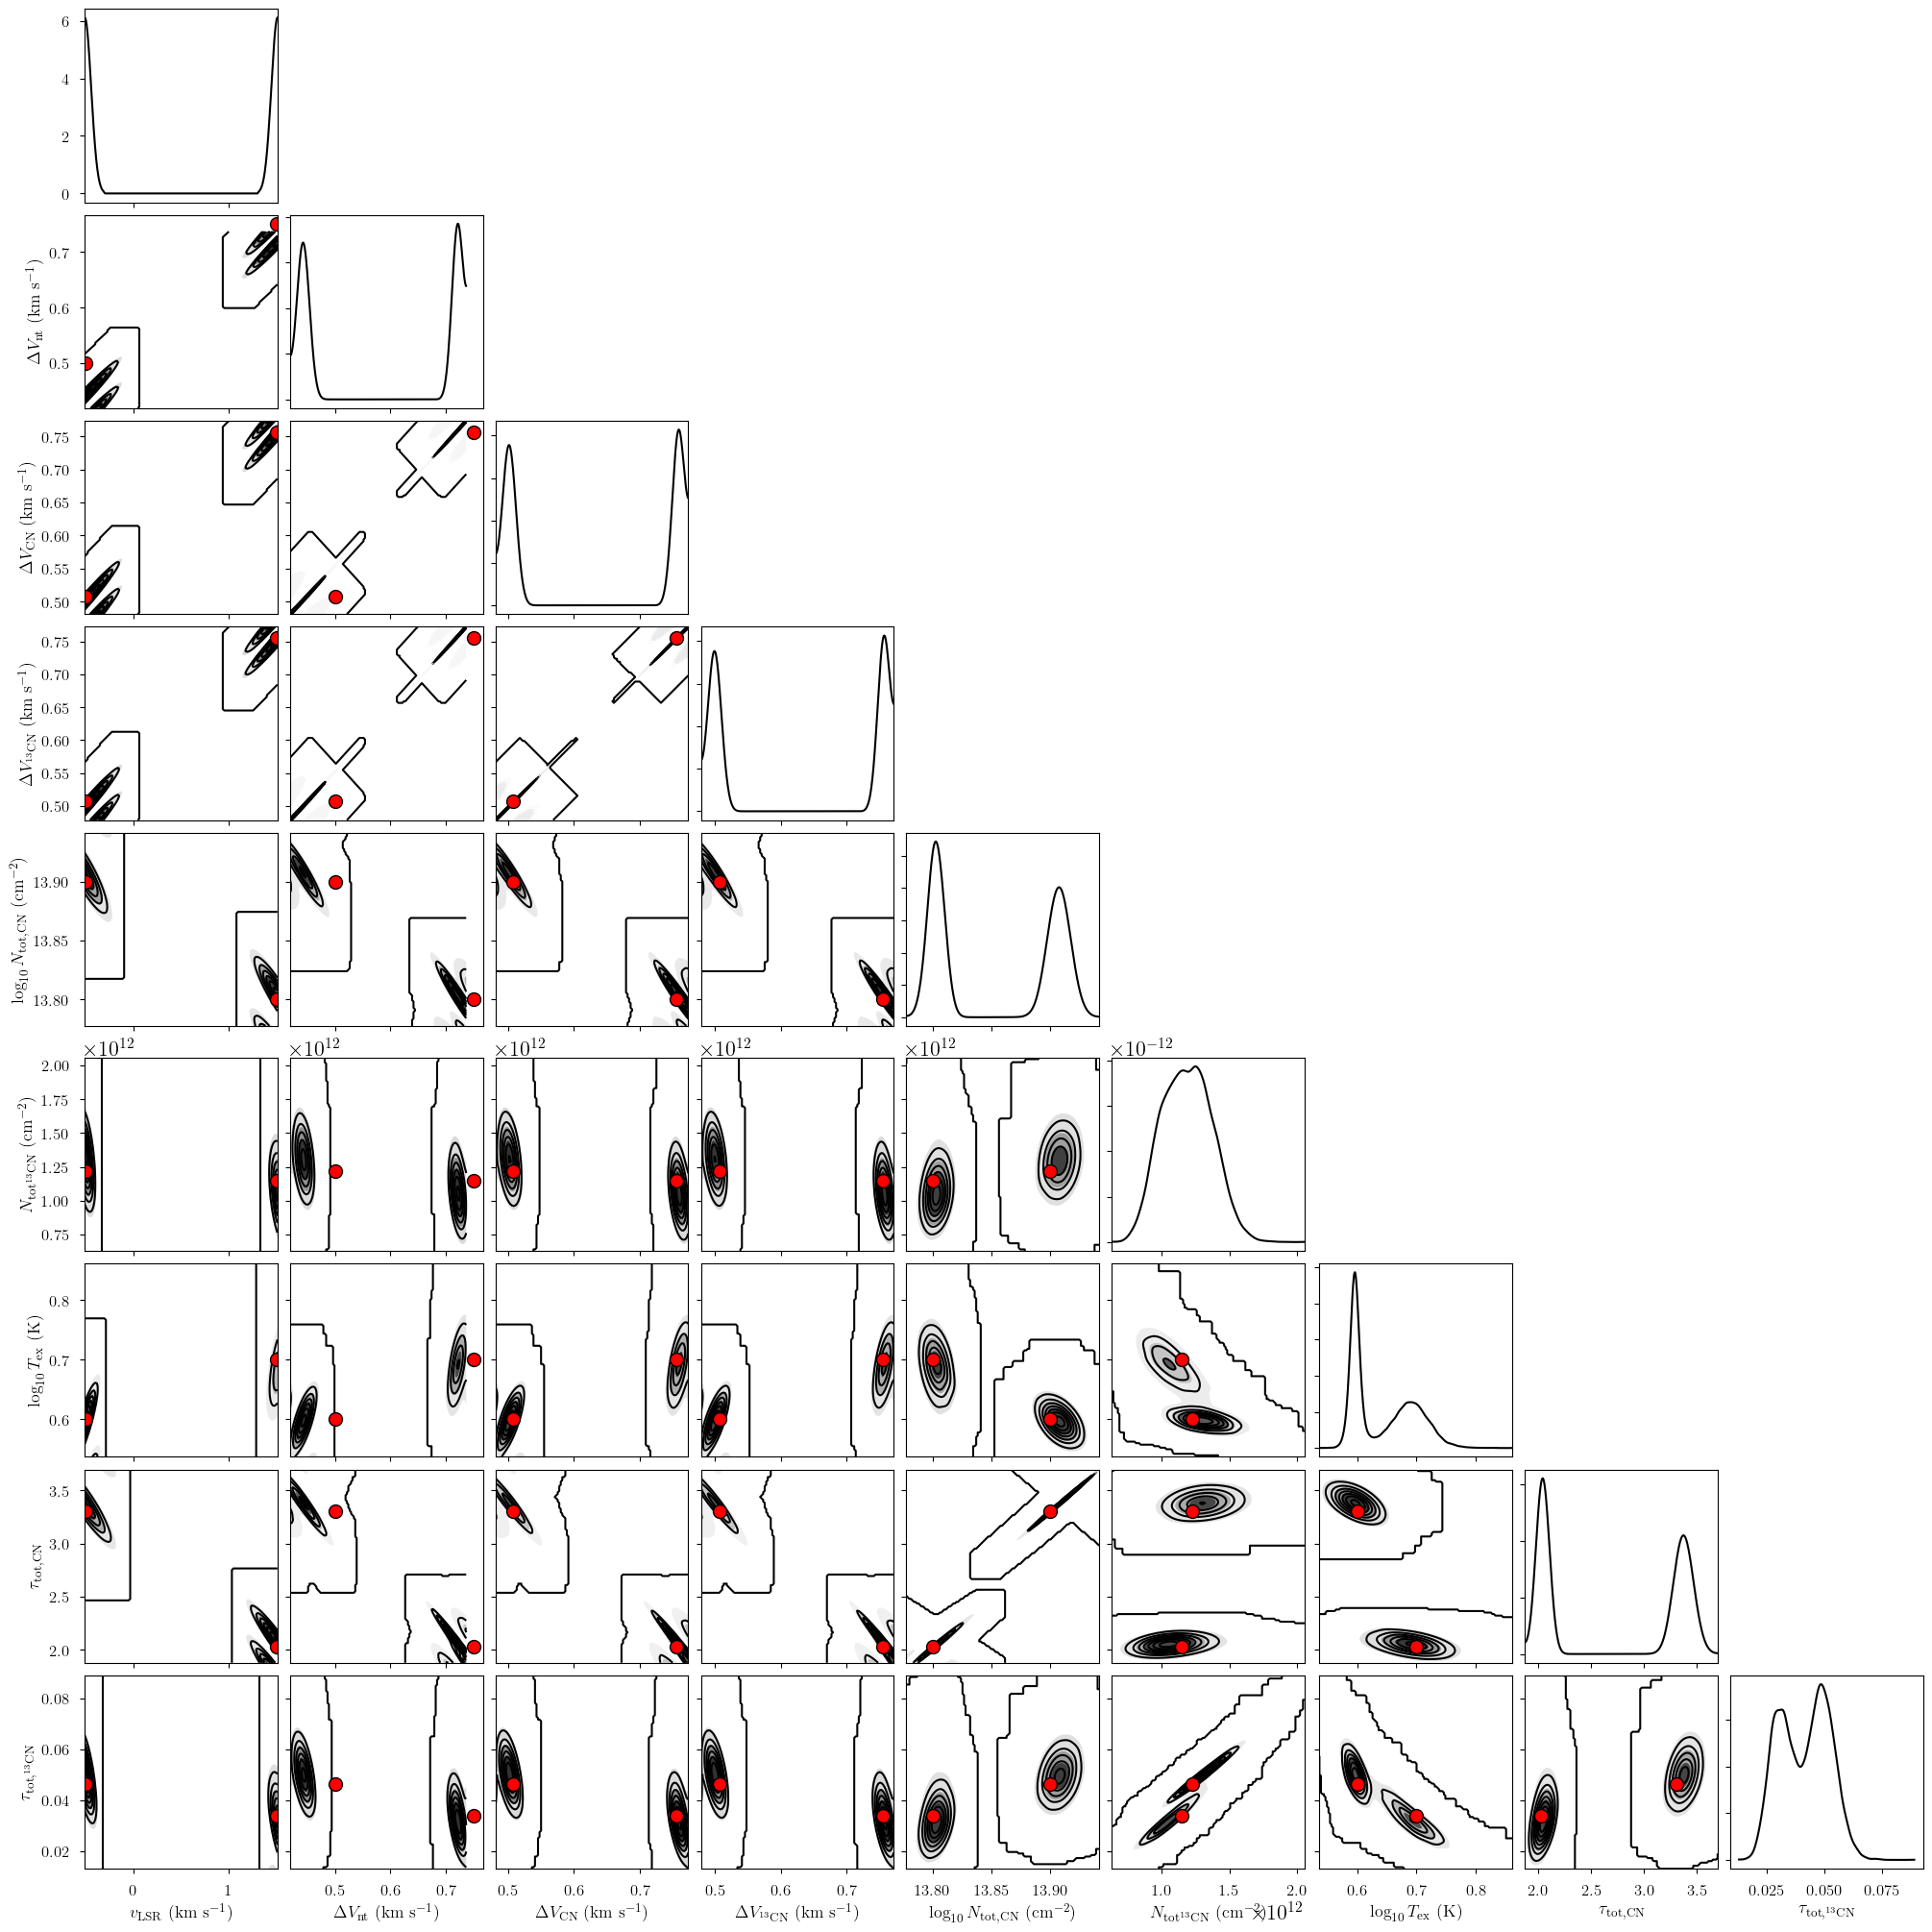

In [15]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    )) and param not in ["fwhm_thermal_12CN", "fwhm_thermal_13CN"]
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

['velocity', 'fwhm_nonthermal', 'fwhm_12CN', 'fwhm_13CN', 'log10_N_12CN', 'N_13CN', 'log10_Tex_ul', 'tau_total_12CN', 'tau_total_13CN', 'ratio_12C_13C']


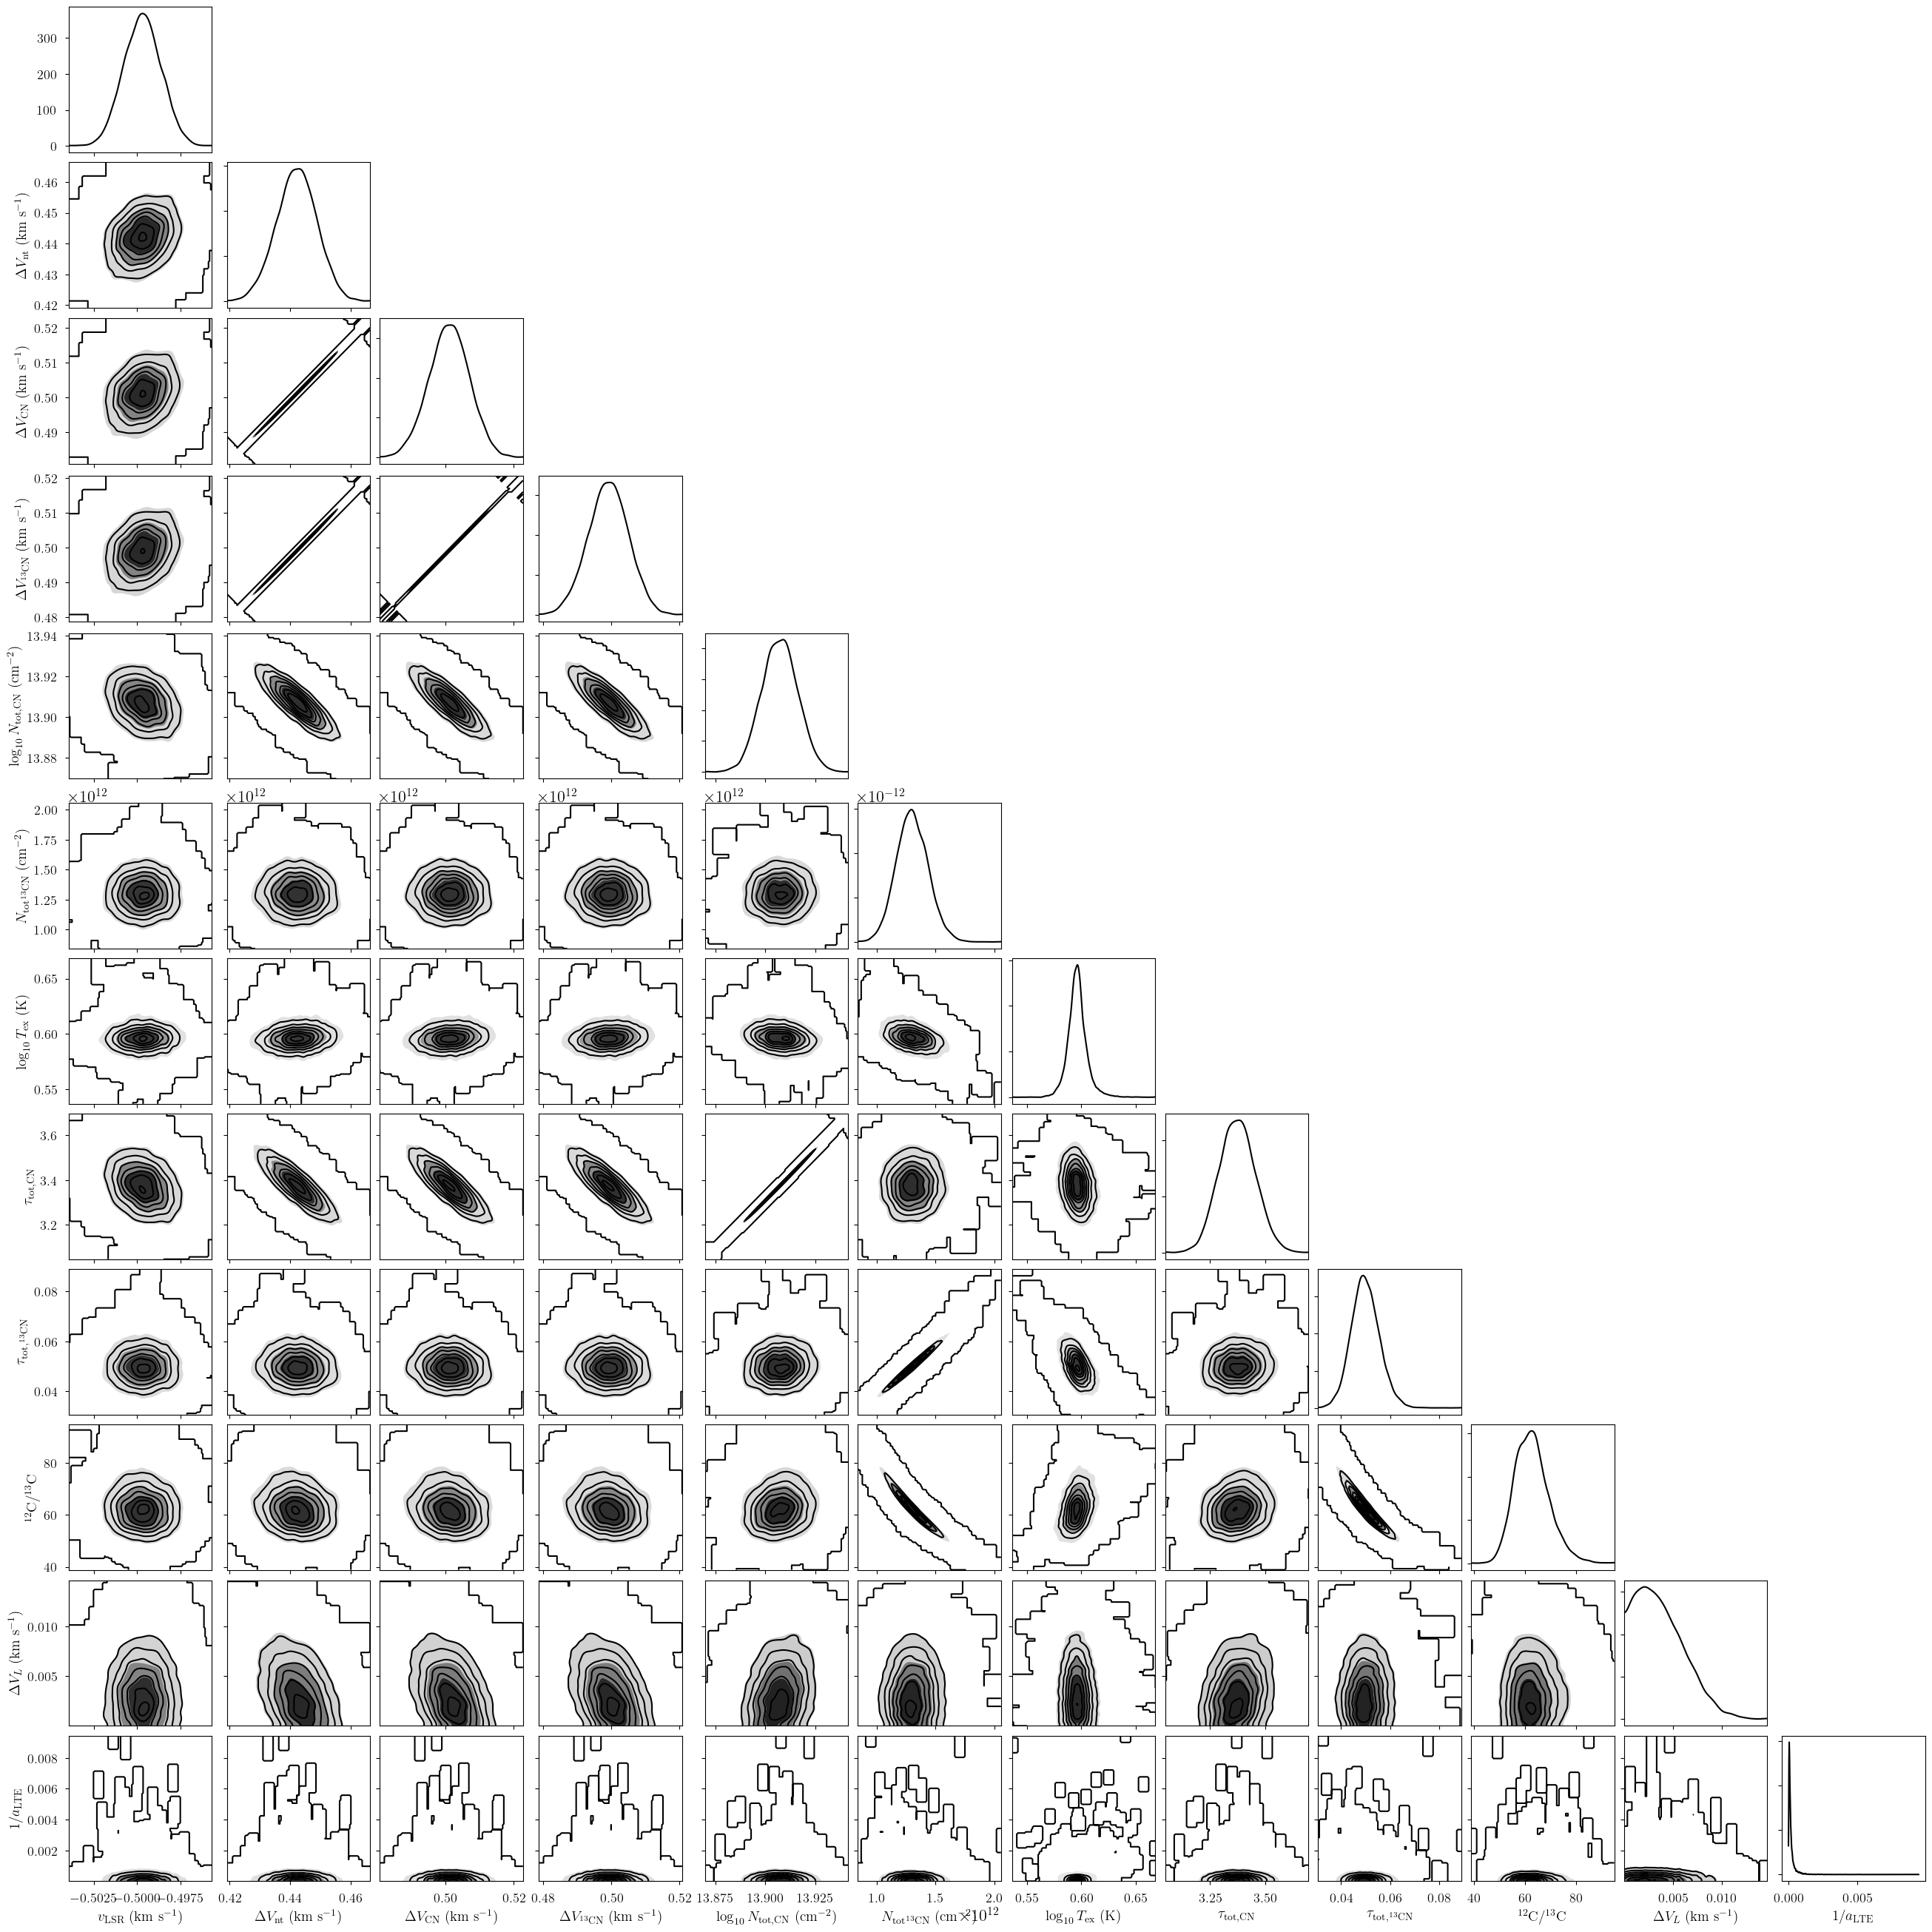

In [16]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics + ["ratio_12C_13C"]
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    )) and param not in ["fwhm_thermal_12CN", "fwhm_thermal_13CN"]
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics + ["LTE_precision"], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde",
)

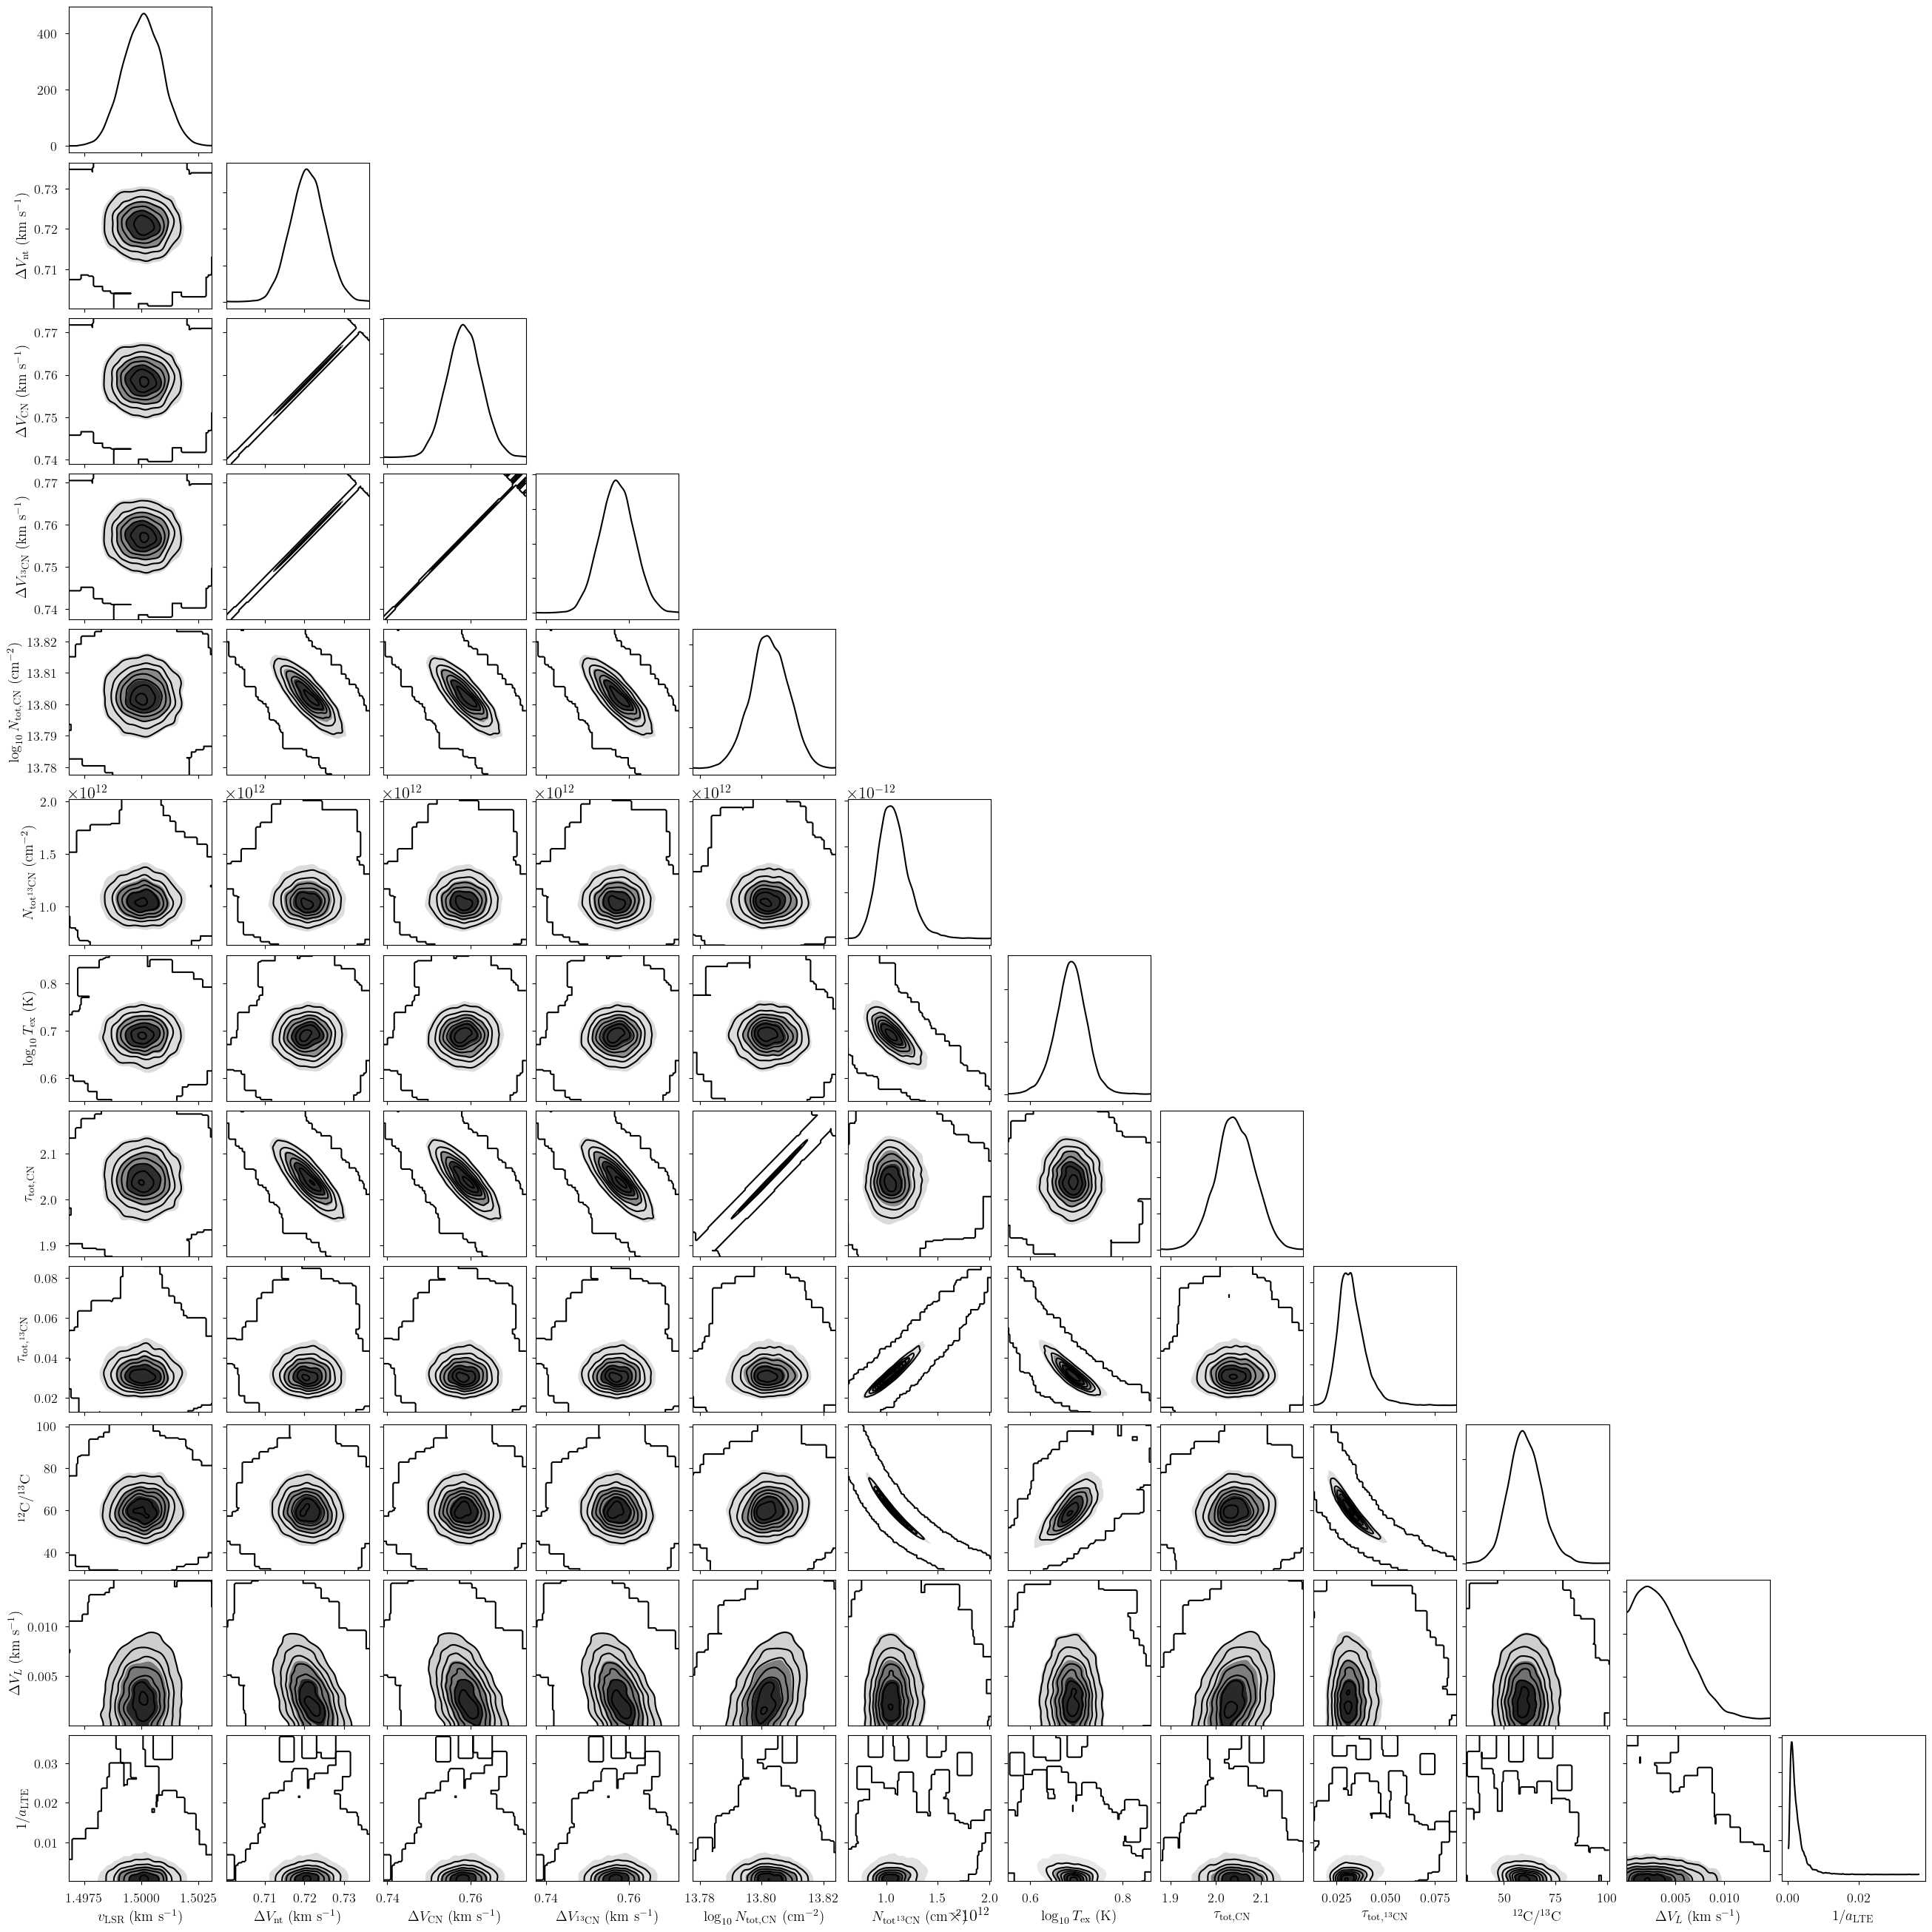

In [17]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics + ["LTE_precision"], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde",
)

In [18]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_freeRVs + model.hyper_deterministics + ["ratio_12C_13C"]
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -9505.325924164972


mean            sd       hdi_16%  \
velocity[0]              -5.000000e-01  1.000000e-03 -5.010000e-01   
velocity[1]               1.500000e+00  1.000000e-03  1.499000e+00   
fwhm_thermal_12CN[0]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_12CN[1]      2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_13CN[0]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_thermal_13CN[1]      2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_nonthermal[0]        4.420000e-01  7.000000e-03  4.360000e-01   
fwhm_nonthermal[1]        7.210000e-01  4.000000e-03  7.170000e-01   
fwhm_12CN[0]              5.010000e-01  6.000000e-03  4.960000e-01   
fwhm_12CN[1]              7.590000e-01  4.000000e-03  7.550000e-01   
fwhm_13CN[0]              4.990000e-01  6.000000e-03  4.930000e-01   
fwhm_13CN[1]              7.570000e-01  4.000000e-03  7.530000e-01   
log10_N_12CN[0]           1.390700e+01  9.000000e-03  1.389800e+01   
log10_N_12CN[1]           1.380200e+01  6.000000e-03  1.379700e+01   
N_13CN[0]                 1.302064e+12  1.350778e+11  1.159116e+12   
N_13CN[1]                 1.071082e+12  1.475038e+11  9.134501e+11   
log10_Tex_ul[0]           5.960000e-01  9.000000e-03  5.880000e-01   
log10_Tex_ul[1]           6.890000e-01  3.400000e-02  6.570000e-01   
Tex_12CN[113123.3687, 0]  3.847000e+00  2.100000e-02  3.825000e+00   
Tex_12CN[113123.3687, 1]  4.853000e+00  3.800000e-02  4.811000e+00   
Tex_12CN[113144.19, 0]    3.785000e+00  1.700000e-02  3.767000e+00   
Tex_12CN[113144.19, 1]    5.893000e+00  6.500000e-02  5.825000e+00   
Tex_12CN[113170.535, 0]   3.979000e+00  2.100000e-02  3.956000e+00   
Tex_12CN[113170.535, 1]   4.663000e+00  3.000000e-02  4.631000e+00   
Tex_12CN[113191.325, 0]   3.912000e+00  1.800000e-02  3.894000e+00   
Tex_12CN[113191.325, 1]   5.614000e+00  5.400000e-02  5.557000e+00   
Tex_12CN[113488.142, 0]   3.952000e+00  1.900000e-02  3.932000e+00   
Tex_12CN[113488.142, 1]   4.231000e+00  2.200000e-02  4.208000e+00   
Tex_12CN[113490.985, 0]   4.001000e+00  7.000000e-03  3.995000e+00   
Tex_12CN[113490.985, 1]   5.213000e+00  2.500000e-02  5.189000e+00   
Tex_12CN[113499.643, 0]   3.977000e+00  2.100000e-02  3.956000e+00   
Tex_12CN[113499.643, 1]   4.656000e+00  3.100000e-02  4.623000e+00   
Tex_12CN[113508.934, 0]   3.887000e+00  1.800000e-02  3.868000e+00   
Tex_12CN[113508.934, 1]   4.998000e+00  4.100000e-02  4.955000e+00   
Tex_12CN[113520.4215, 0]  3.911000e+00  2.100000e-02  3.890000e+00   
Tex_12CN[113520.4215, 1]  5.601000e+00  5.900000e-02  5.537000e+00   
tau_12CN[113123.3687, 0]  4.100000e-02  1.000000e-03  3.900000e-02   
tau_12CN[113123.3687, 1]  2.800000e-02  1.000000e-03  2.800000e-02   
tau_12CN[113144.19, 0]    3.420000e-01  8.000000e-03  3.330000e-01   
tau_12CN[113144.19, 1]    1.710000e-01  4.000000e-03  1.670000e-01   
tau_12CN[113170.535, 0]   3.190000e-01  8.000000e-03  3.110000e-01   
tau_12CN[113170.535, 1]   2.330000e-01  5.000000e-03  2.280000e-01   
tau_12CN[113191.325, 0]   4.270000e-01  1.100000e-02  4.170000e-01   
tau_12CN[113191.325, 1]   2.240000e-01  5.000000e-03  2.180000e-01   
tau_12CN[113488.142, 0]   4.170000e-01  1.100000e-02  4.070000e-01   
tau_12CN[113488.142, 1]   3.190000e-01  6.000000e-03  3.130000e-01   
tau_12CN[113490.985, 0]   1.127000e+00  2.600000e-02  1.099000e+00   
tau_12CN[113490.985, 1]   6.220000e-01  1.300000e-02  6.100000e-01   
tau_12CN[113499.643, 0]   3.280000e-01  8.000000e-03  3.190000e-01   
tau_12CN[113499.643, 1]   2.400000e-01  5.000000e-03  2.350000e-01   
tau_12CN[113508.934, 0]   3.320000e-01  8.000000e-03  3.230000e-01   
tau_12CN[113508.934, 1]   1.850000e-01  4.000000e-03  1.810000e-01   
tau_12CN[113520.4215, 0]  4.100000e-02  1.000000e-03  4.000000e-02   
tau_12CN[113520.4215, 1]  2.200000e-02  1.000000e-03  2.100000e-02   
tau_total_12CN[0]         3.374000e+00  8.200000e-02  3.292000e+00   
tau_total_12CN[1]         2.043000e+00  4.300000e-02  2.002000e+00   
TR_12CN[113123.3687, 0]   1.751000e+00  1.80

The solution is good, but we made the strong assumption that $^{13}{\rm CN}$ does not suffer from hyperfine anomalies. Since only a few transitions are bright enough to be detected, there is no evidence to suggest that hyperfine anomalies are or are not present in the $^{13}{\rm CN}$ data.

## $^{13}{\rm CN}$ Hyperfine Anomalies

Instead of assuming CTEX for $^{13}{\rm CN}$, we can instead assume that the hyperfine anomalies are similar across both species. Specifically, we assume that the LTE precision parameter, which characterizes the variance in state column densities relative to their LTE values, is the same for both species. Presumably this will increase the uncertainty in the excitation temperature of the detected $^{13}{\rm CN}$ transitions and subsequently the uncertainty in the $^{12}{\rm C}/^{13}{\rm C}$ ratio.

In [19]:
# Initialize and define the model
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.75, 0.25], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [75.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = None, # kinetic temperature is fixed
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.5, 0.1], # mean and width of excitation temperature prior (K)
    assume_CTEX_12CN = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    assume_CTEX_13CN = False, # do not assume CTEX for 13CN
    fix_log10_Tkin = 1.5, # kinetic temperature is fixed (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2, LTE_precision, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, log10_Tex_ul_norm, ratio_12C_13C, velocity_norm, weights_12CN, weights_13CN]


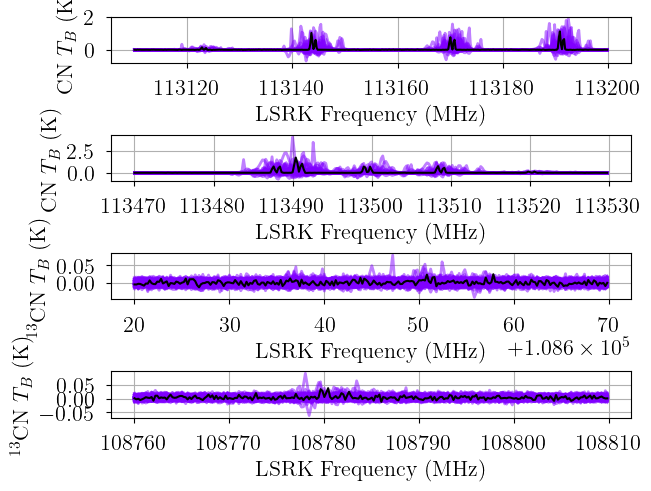

In [20]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [21]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.02, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 33900
Interrupted at 33,899 [33%]: Average Loss = 16,853


Output()

Runtime: 2.72 minutes


Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

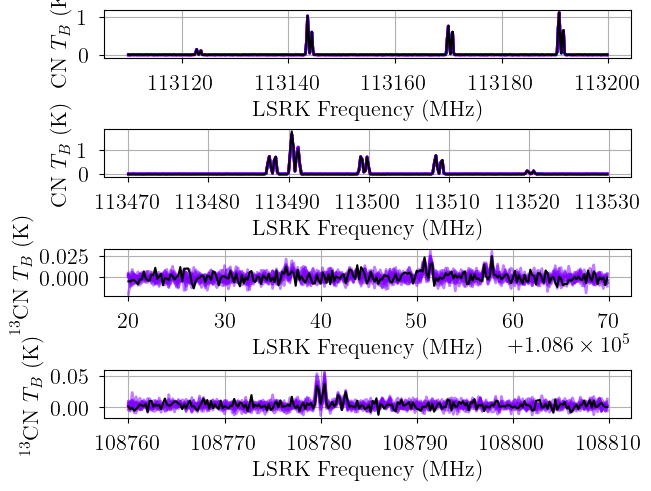

In [22]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [23]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.02}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 33900
Interrupted at 33,899 [33%]: Average Loss = 16,853
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_12CN_norm, ratio_12C_13C, log10_Tex_ul_norm, LTE_precision, weights_12CN, weights_13CN]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 546 seconds.


Adding log-likelihood to trace


Output()

There were 2 divergences in converged chains.
Runtime: 11.92 minutes


In [24]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [25]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs + ["ratio_12C_13C", "LTE_precision"])

solutions: [0]


/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean            sd        hdi_3%  \
velocity[0]              1.500000e+00  1.000000e-03  1.498000e+00   
velocity[1]             -5.000000e-01  1.000000e-03 -5.020000e-01   
fwhm_thermal_12CN[0]     2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_12CN[1]     2.360000e-01  0.000000e+00  2.360000e-01   
fwhm_thermal_13CN[0]     2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_thermal_13CN[1]     2.320000e-01  0.000000e+00  2.320000e-01   
fwhm_nonthermal[0]       7.210000e-01  4.000000e-03  7.120000e-01   
fwhm_nonthermal[1]       4.420000e-01  7.000000e-03  4.300000e-01   
fwhm_12CN[0]             7.580000e-01  4.000000e-03  7.500000e-01   
fwhm_12CN[1]             5.010000e-01  6.000000e-03  4.900000e-01   
fwhm_13CN[0]             7.570000e-01  4.000000e-03  7.490000e-01   
fwhm_13CN[1]             4.990000e-01  6.000000e-03  4.880000e-01   
log10_N_12CN[0]          1.380300e+01  6.000000e-03  1.379200e+01   
log10_N_12CN[1]          1.390700e+01  9.000000e-03  1.389000e+01   
N_13CN[0]                9.817452e+11  1.389517e+11  7.350717e+11   
N_13CN[1]                1.286064e+12  1.472292e+11  1.026317e+12   
log10_Tex_ul[0]          6.960000e-01  2.600000e-02  6.460000e-01   
log10_Tex_ul[1]          5.960000e-01  9.000000e-03  5.790000e-01   
tau_total_12CN[0]        2.044000e+00  4.200000e-02  1.960000e+00   
tau_total_12CN[1]        3.371000e+00  8.300000e-02  3.215000e+00   
tau_total_13CN[0]        2.900000e-02  6.000000e-03  1.800000e-02   
tau_total_13CN[1]        4.900000e-02  7.000000e-03  3.800000e-02   
fwhm_L                   4.000000e-03  2.000000e-03  0.000000e+00   
baseline_12CN-1_norm[0] -1.080000e-01  4.800000e-02 -2.020000e-01   
baseline_12CN-2_norm[0] -2.720000e-01  6.200000e-02 -3.940000e-01   
baseline_13CN-1_norm[0] -1.170000e-01  6.600000e-02 -2.370000e-01   
baseline_13CN-2_norm[0] -3.200000e-02  6.400000e-02 -1.510000e-01   
ratio_12C_13C[0]         6.594700e+01  9.438000e+00  4.917100e+01   
ratio_12C_13C[1]         6.358400e+01  7.515000e+00  5.062900e+01   
LTE_precision[0]         1.000000e-03  1.000000e-03  0.000000e+00   
LTE_precision[1]         0.000000e+00  0.000000e+00  0.000000e+00   

                              hdi_97%     mcse_mean       mcse_sd  ess_bulk  \
velocity[0]              1.502000e+00  0.000000e+00  0.000000e+00    9425.0   
velocity[1]             -4.980000e-01  0.000000e+00  0.000000e+00    5715.0   
fwhm_thermal_12CN[0]     2.360000e-01  0.000000e+00  0.000000e+00    8000.0   
fwhm_thermal_12CN[1]     2.360000e-01  0.000000e+00  0.000000e+00    8000.0   
fwhm_thermal_13CN[0]     2.320000e-01  0.000000e+00  0.000000e+00    8000.0   
fwhm_thermal_13CN[1]     2.320000e-01  0.000000e+00  0.000000e+00    8000.0   
fwhm_nonthermal[0]       7.280000e-01  0.000000e+00  0.000000e+00    2086.0   
fwhm_nonthermal[1]       4.550000e-01  0.000000e+00  0.000000e+00    1605.0   
fwhm_12CN[0]             7.660000e-01  0.000000e+00  0.000000e+00    2086.0   
fwhm_12CN[1]             5.120000e-01  0.000000e+00  0.000000e+00    1605.0   
fwhm_13CN[0]             7.640000e-01  0.000000e+00  0.000000e+00    2086.0   
fwhm_13CN[1]             5.100000e-01  0.000000e+00  0.000000e+00    1605.0   
log10_N_12CN[0]          1.381400e+01  0.000000e+00  0.000000e+00    1599.0   
log10_N_12CN[1]          1.392400e+01  0.000000e+00  0.000000e+00    1326.0   
N_13CN[0]                1.250198e+12  2.005096e+09  1.654500e+09    4681.0   
N_13CN[1]                1.574764e+12  1.888439e+09  1.853602e+09    6045.0   
log10_Tex_ul[0]          7.470000e-01  0.000000e+00  0.000000e+00    5317.0   
log10_Tex_ul[1]          6.120000e-01  0.000000e+00  0.000000e+00    4825.0   
tau_total_12CN[0]        2.119000e+00  1.000000e-03  1.000000e-03    1581.0   
tau_total_12CN[1]        3.525000e+00  2.000000e-03  1.000000e-03    1320.0   
tau_total_13CN[0]        4.100000e-02  0.000000e+00  0.000000e+00    4010.0   
tau_total_13CN[1]        6.200000e-02  0.000000e+00  0.000000e+00    5094.0   
fwhm_L 

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

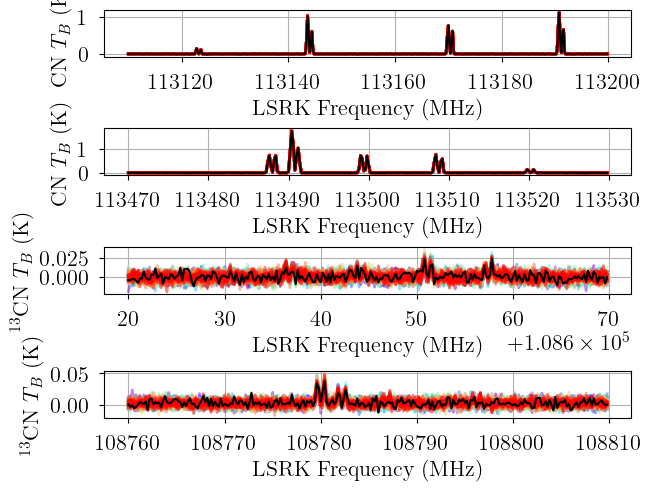

In [26]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

['velocity', 'fwhm_nonthermal', 'fwhm_12CN', 'fwhm_13CN', 'log10_N_12CN', 'N_13CN', 'log10_Tex_ul', 'tau_total_12CN', 'tau_total_13CN']


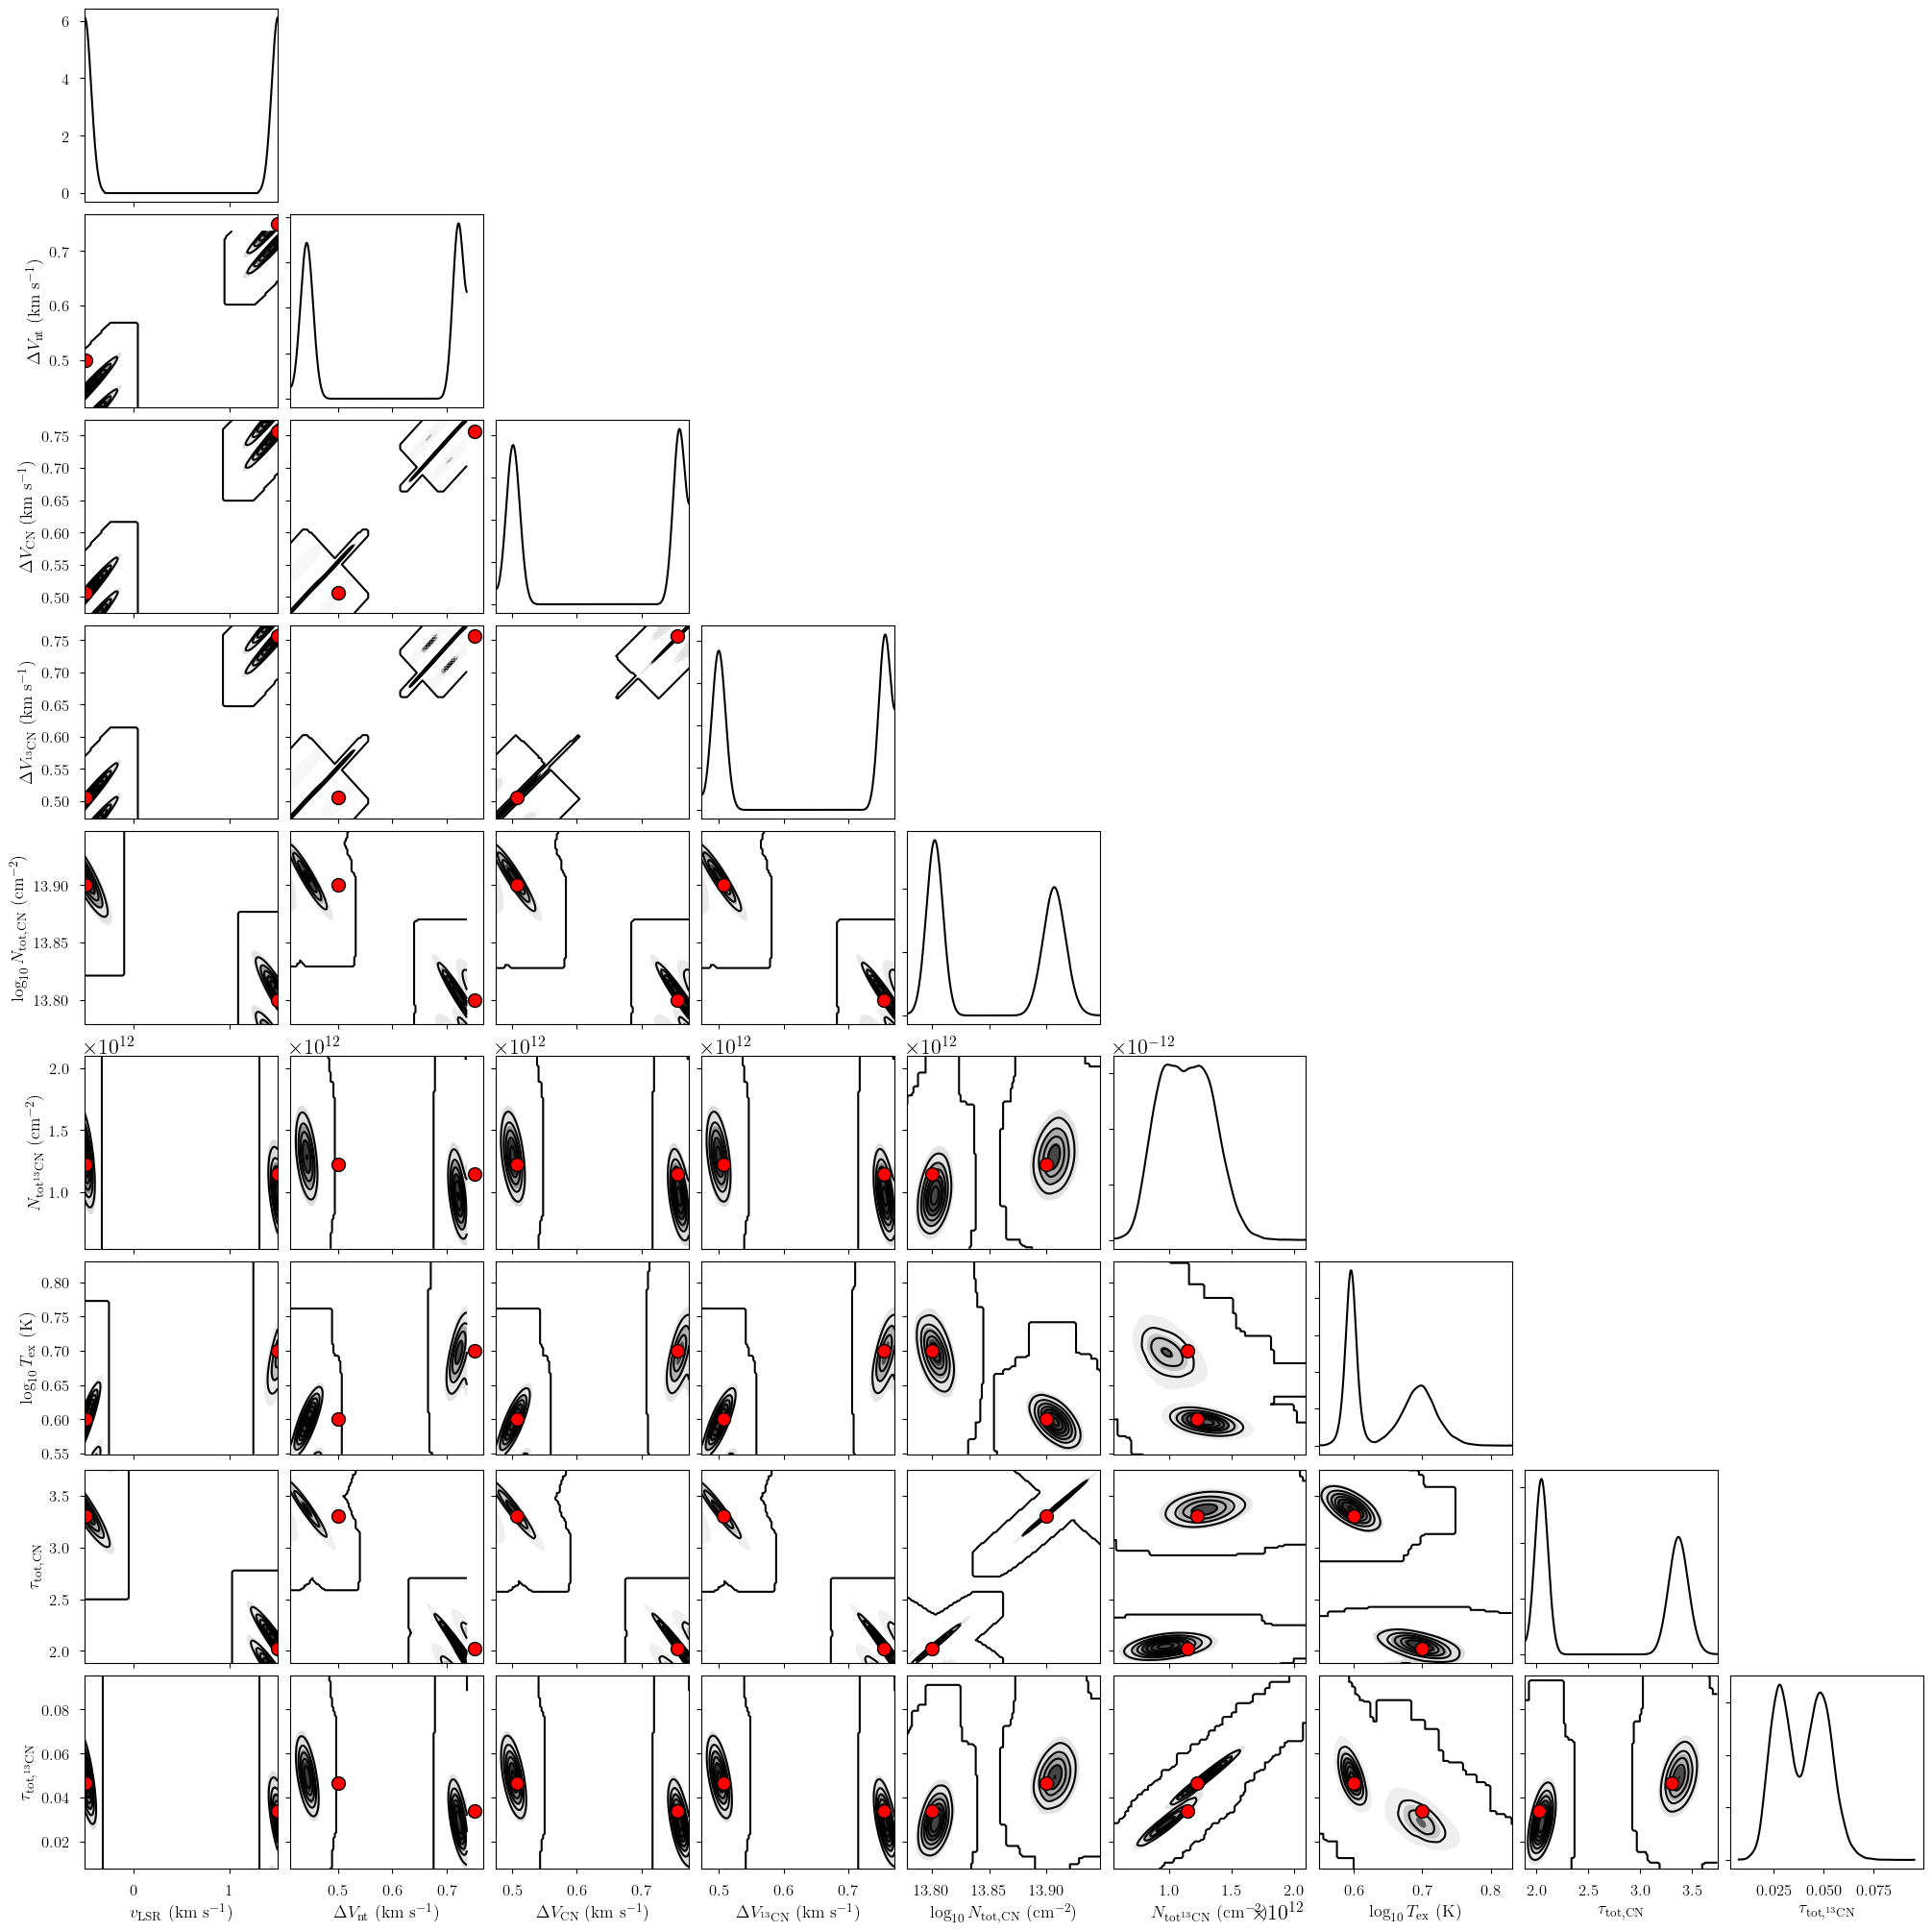

In [27]:
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    )) and param not in ["fwhm_thermal_12CN", "fwhm_thermal_13CN"]
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

['velocity', 'fwhm_nonthermal', 'fwhm_12CN', 'fwhm_13CN', 'log10_N_12CN', 'N_13CN', 'log10_Tex_ul', 'tau_total_12CN', 'tau_total_13CN', 'ratio_12C_13C', 'LTE_precision']


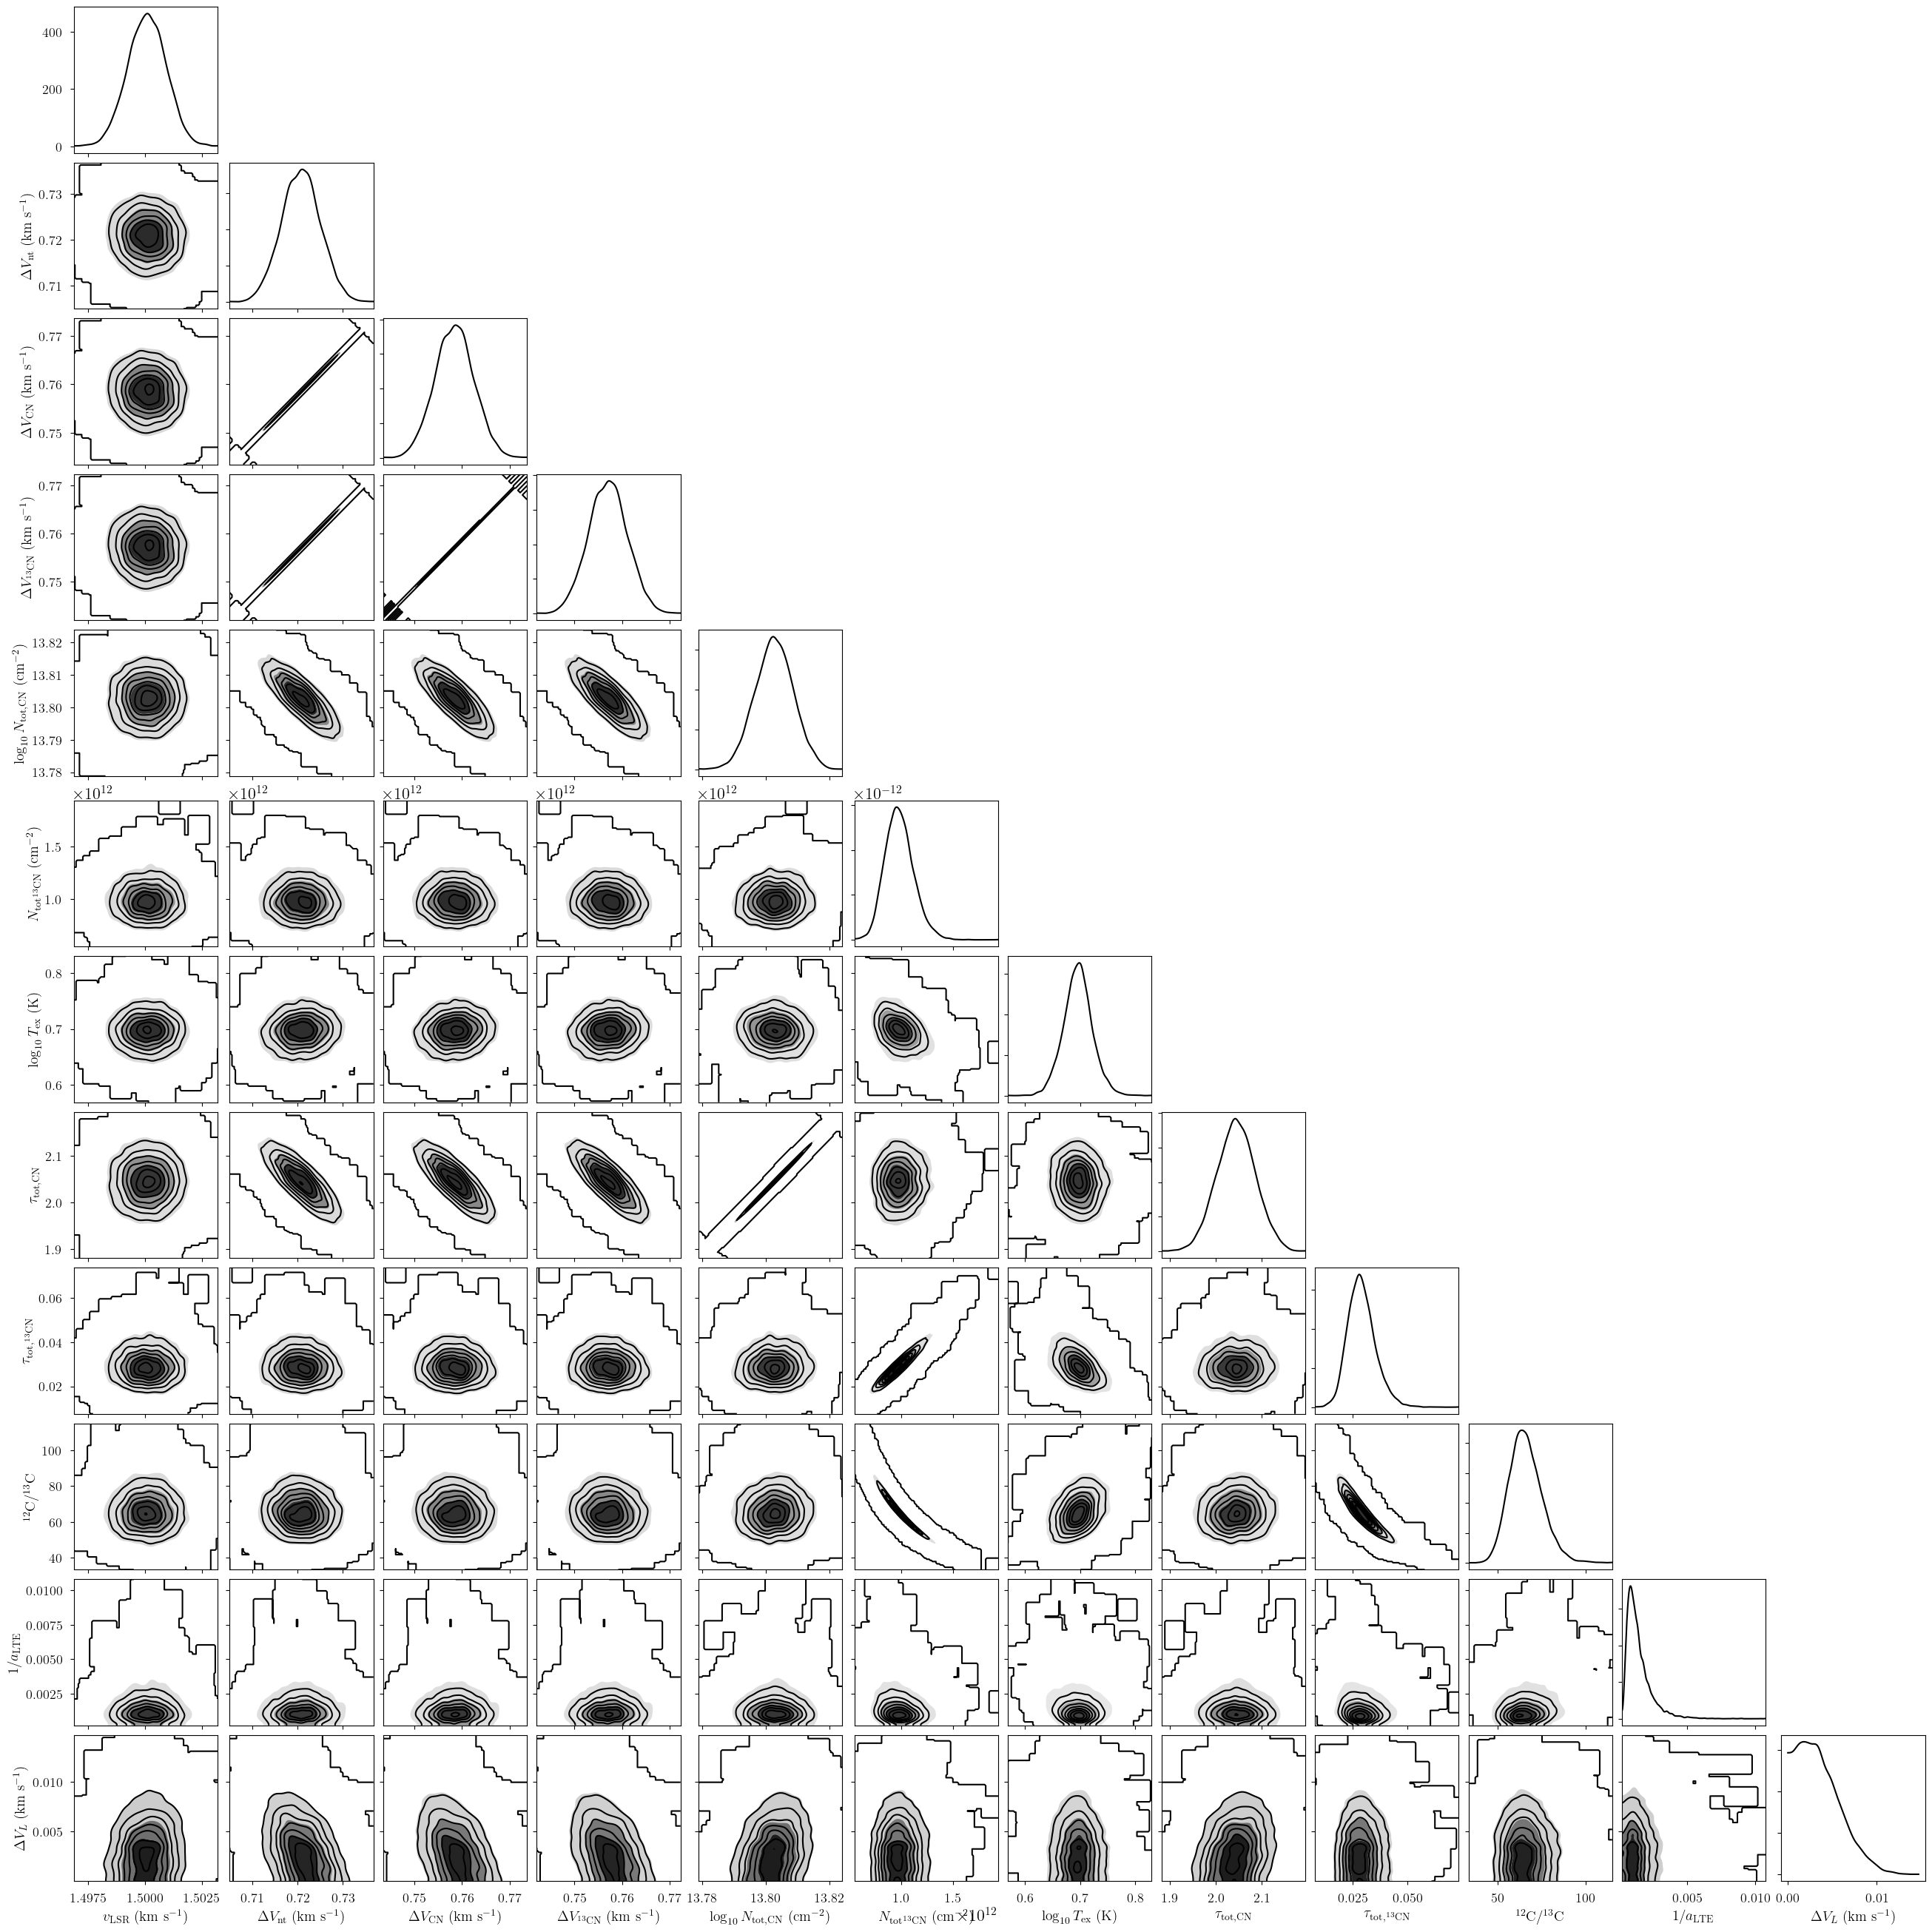

In [29]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics + ["ratio_12C_13C", "LTE_precision"]
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    )) and param not in ["fwhm_thermal_12CN", "fwhm_thermal_13CN"]
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
)

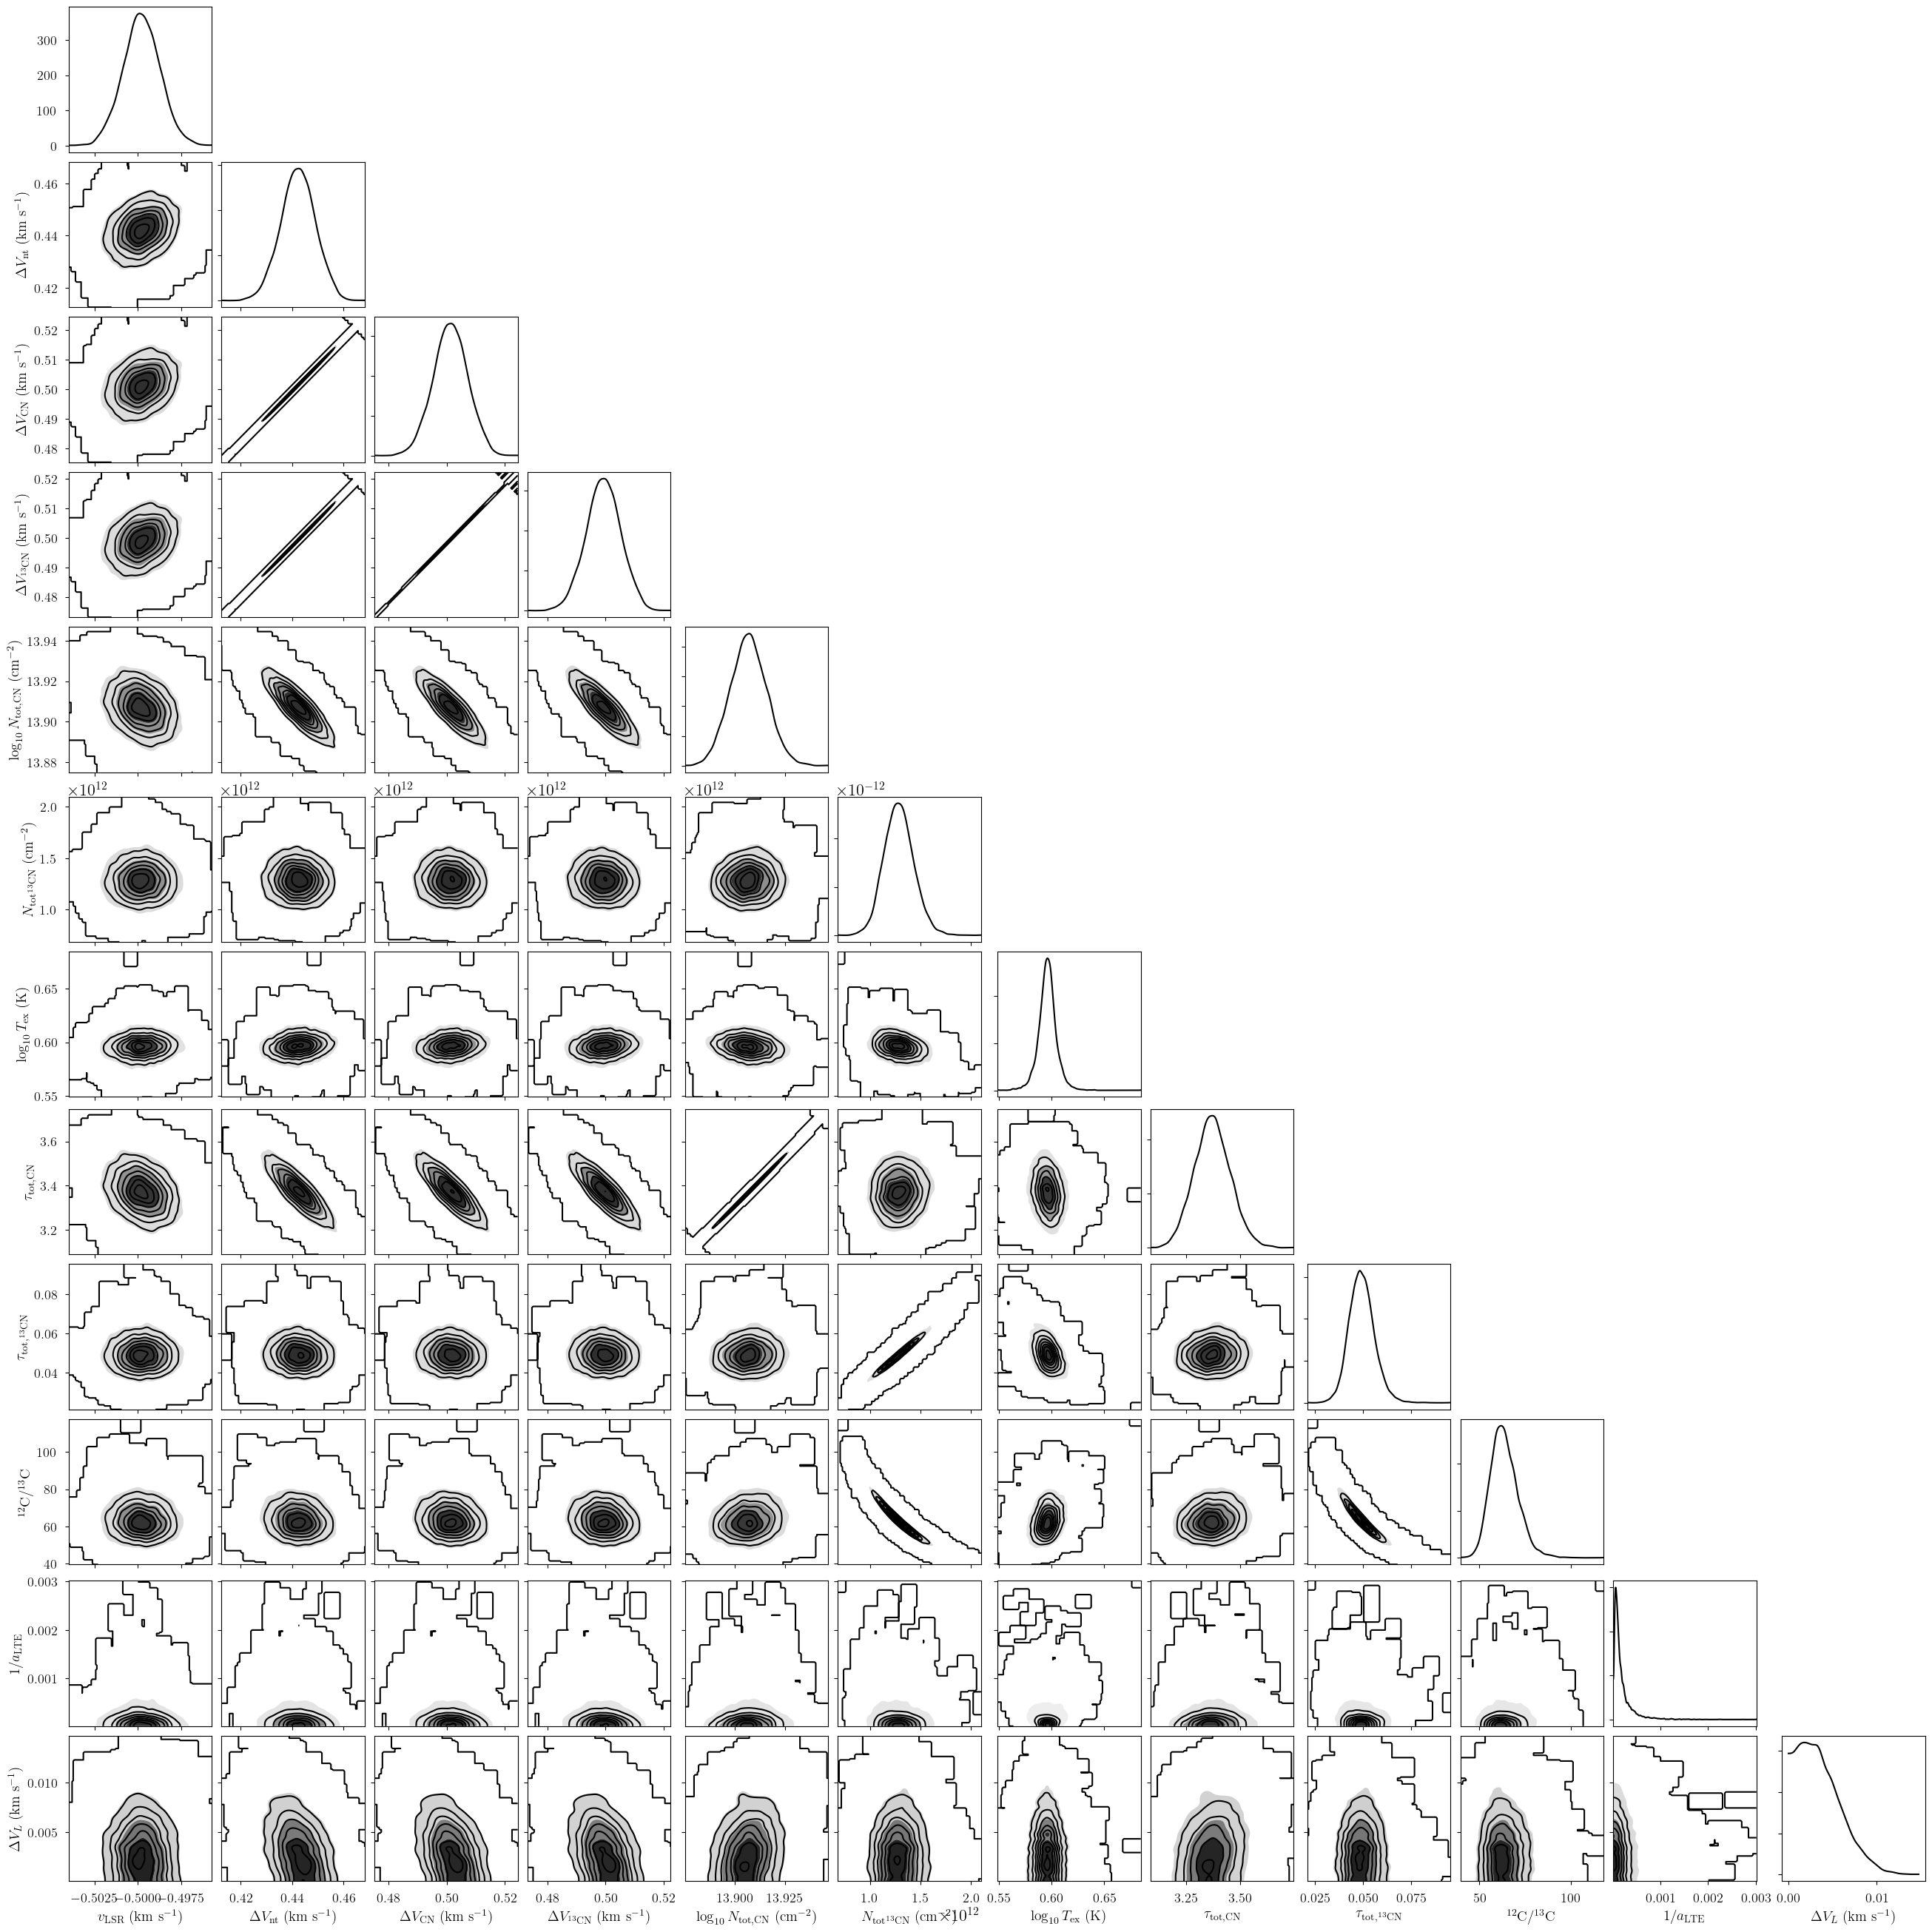

In [30]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
)

Note the slightly larger uncertainty in the isotopic ratio caused by the assumption that $^{13}{\rm CN}$ might have hyperfine anomalies similar to those of $^{12}{\rm CN}$.